In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
import ast

In [27]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [28]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [29]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [30]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [31]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

## 

# Motifs Survival

In [32]:
rawdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_unfiltered.csv')
crosstalkdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_pairs.csv')

significant = crosstalkdf.query('pval_adj < 0.05')
significant = significant.query('not ((hr - se) < 1 and 1 < (hr + se))')

better = significant.copy()
better = better.query('hr_lfc_best > 0.')
better = better.query('c_diff_best > 0.')
better = better.query('(logrank_pval < logrank_pval1) and (logrank_pval < logrank_pval2)')

#better = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/better_pairs.csv')
better.head(3)

interaction      tissue        hr       hr1       hr2  \
0     ADA+ADORA2B&FBN1+ITGA5_ITGB1  Pan_Cancer  2.473422  1.449832  1.453431   
1  COL6A3+ITGA10_ITGB1&ADA+ADORA2B  Pan_Cancer  2.690729  1.434415  1.449832   
2     FN1+ITGA11_ITGB1&ADA+ADORA2B  Pan_Cancer  2.452652  1.395628  1.449832   

   concordance_index  concordance_index1  concordance_index2   logrank_pval  \
0           0.525176            0.520904            0.522021  1.996489e-290   
1           0.522922            0.516268            0.520904  2.855622e-255   
2           0.526302            0.520509            0.520904  1.348607e-251   

   logrank_pval1  ...  min_patients  min_patients1  min_patients2   log2_hr  \
0  2.866094e-192  ...         46629         112035         101772  1.306508   
1  2.507191e-171  ...         29337          76494         112035  1.427997   
2  3.625836e-201  ...         37092          93621         112035  1.294343   

   log2_hr1  log2_hr2       pval_adj  hr_lfc_best  c_diff_best           motif  
0  0.535886  0.539462  1.599185e-284     0.767046     0.003155          4_path  
1  0.520463  0.535886  1.143675e-249     0.892112     0.002018  4_no_crosstalk  
2  0.480914  0.535886  3.600776e-246     0.758457     0.005398  4_no_crosstalk  

[3 rows x 30 columns]

In [33]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_permutations.csv')
motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/counts.csv', index_col='motif')
motifs = motifs['number'] 

df3 = df[[col for col in df.columns if col.startswith('3')]]
df4 = df[[col for col in df.columns if col.startswith('4')]]
motifs3 = motifs.loc[[idx for idx in motifs.index if idx.startswith('3')]]
motifs4 = motifs.loc[[idx for idx in motifs.index if idx.startswith('4')]]

motifs3 = motifs3 / motifs3.sum()
motifs4 = motifs4 / motifs4.sum()
df3 = (df3.T / df3.sum(1)).T
df4 = (df4.T / df4.sum(1)).T

df = df3.join(df4)
motifs = pd.concat([motifs3, motifs4])

means = df.mean()
stds = df.std()

motifs_z = ((motifs - means) / stds).sort_values()
motifs_z.name = 'z'

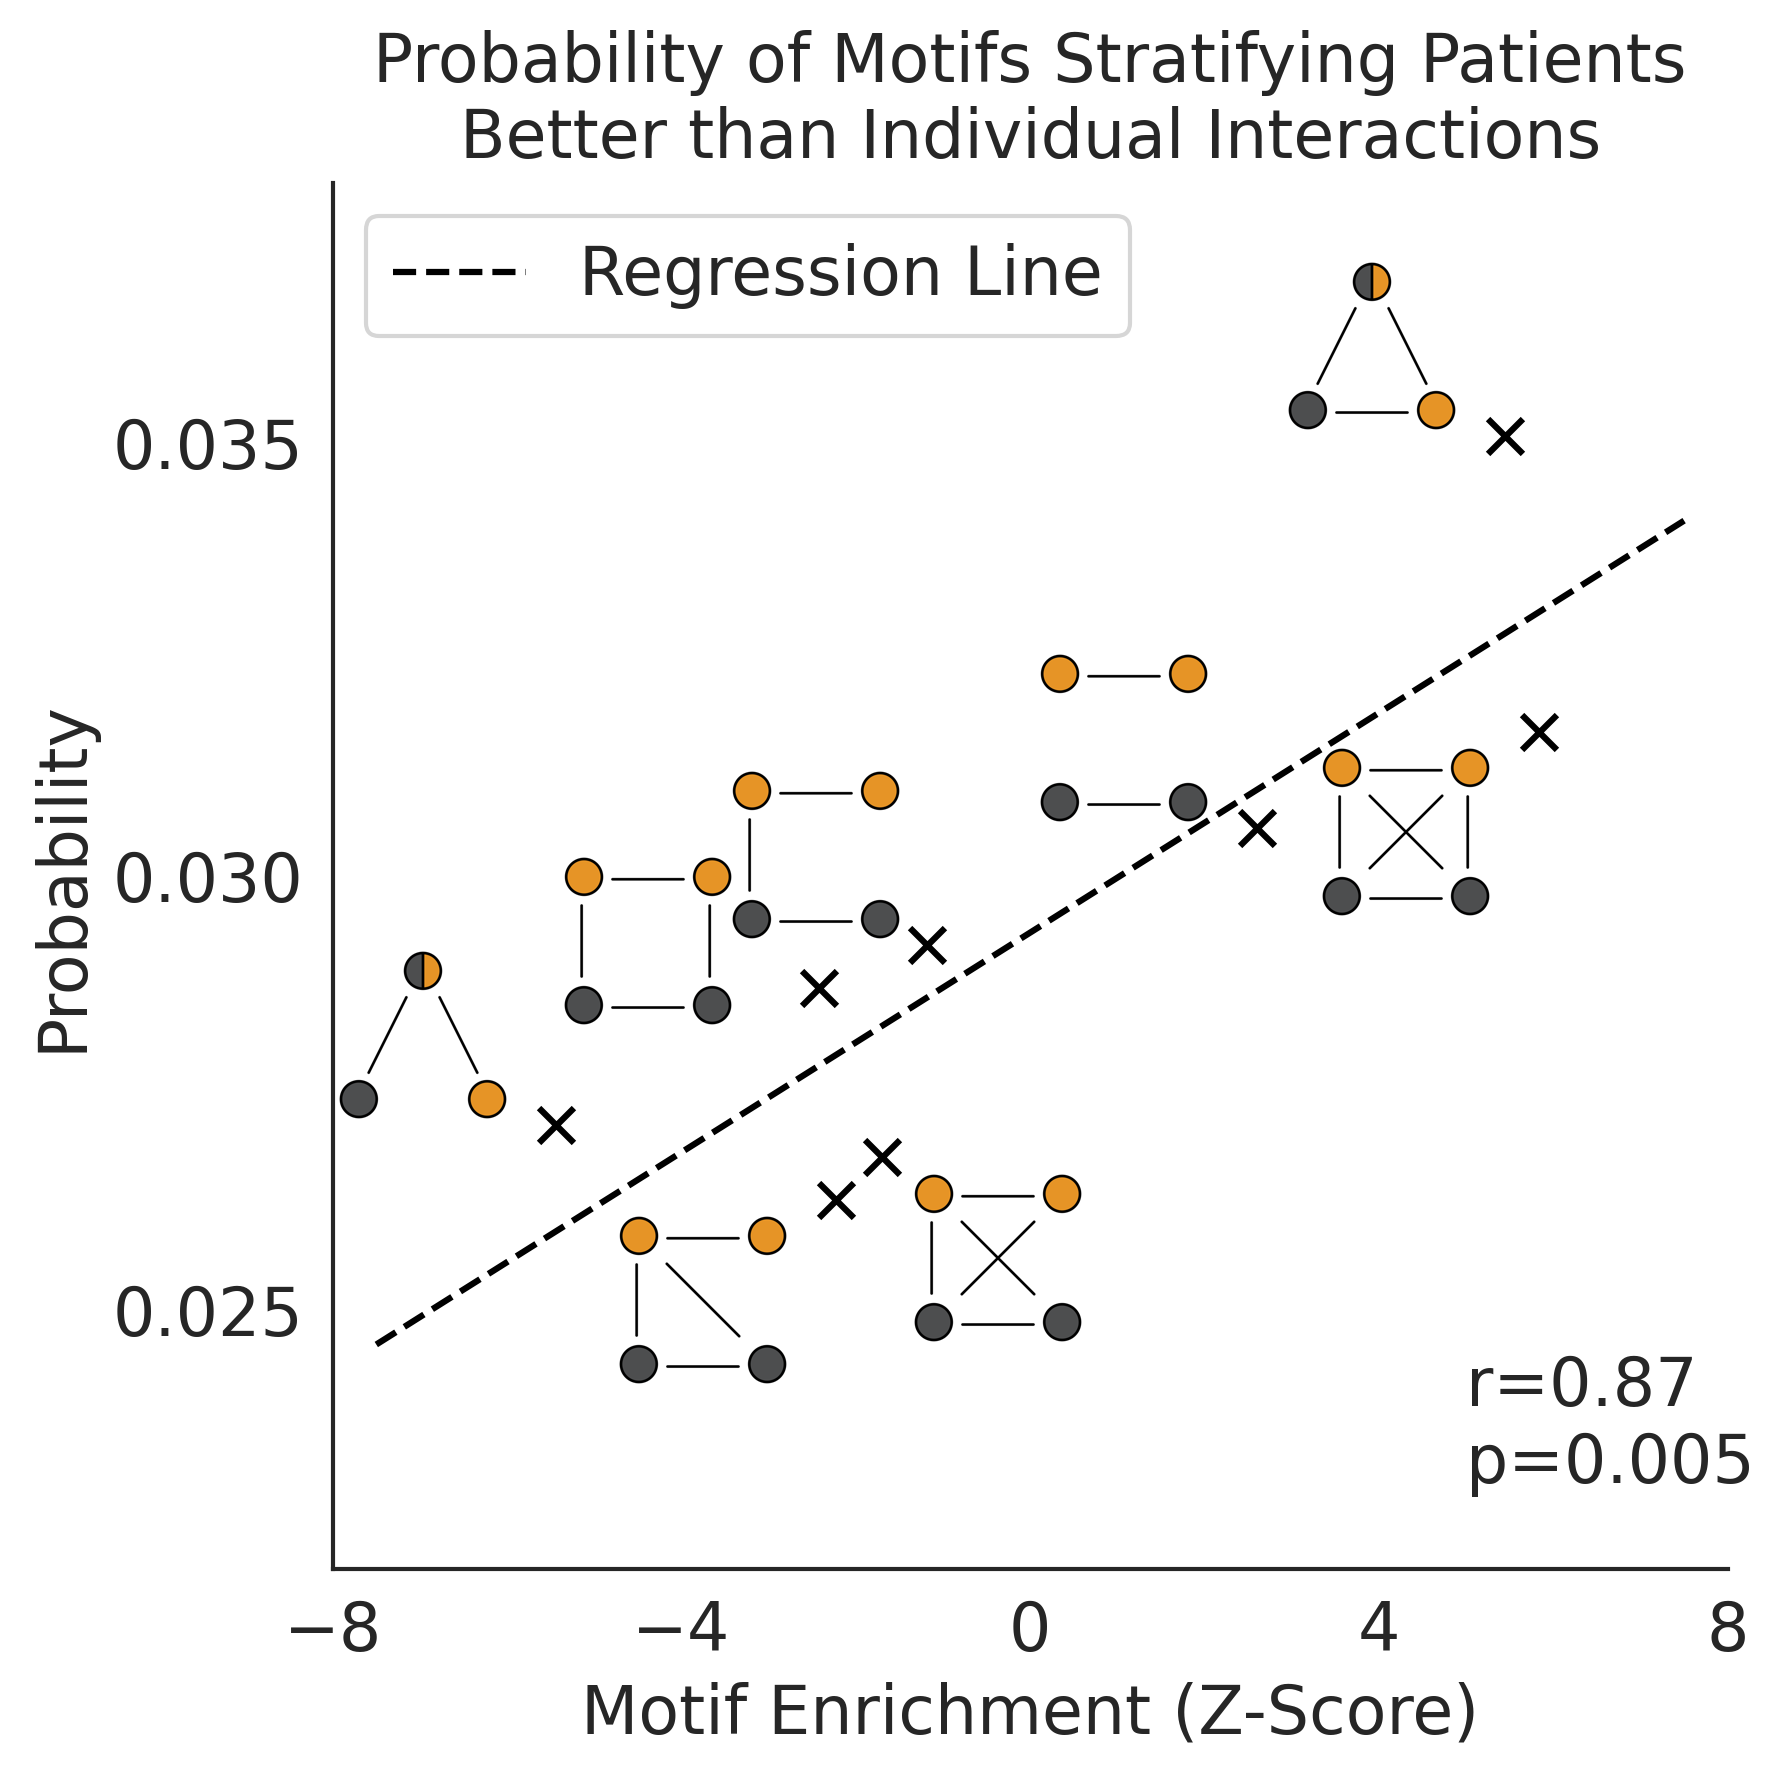

In [34]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import image as mpimg
import os
from PIL import Image

# Constants
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'  # Update this path
image_scaling_factor = 0.3  # Adjust this factor to scale image size (smaller = more zoomed out)
x_offset = -25
y_offset = 100

fs = 16

# Filter data
df = better.query('tissue != "Pan_Cancer"')
all_counts = crosstalkdf.query('tissue != "Pan_Cancer"').motif.value_counts().sort_values(ascending=False)

# Calculate probabilities
probs = (df.motif.value_counts() / all_counts).sort_values()
probs = probs.loc[motifs_z.index]

data = pd.DataFrame()
data['z'] = motifs_z
data['prob'] = probs

# Calculate Pearson correlation
r_value, p_value = pearsonr(probs, motifs_z)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=dpi)

# Plot the scatter points
#ax.scatter(
#    data['z'], 
#    data['prob'], 
#    color=lightgray, 
#    marker='s', 
#    edgecolors='black',  # Black edge color
#    s=70,
#    linewidths=1.5  # Thickness of the edge
#)
ax.scatter(
    data['z'], 
    data['prob'], 
    color='black', 
    marker='x', 
    edgecolors='black',  # Black edge color
    s=70,
    linewidths=1.5  # Thickness of the edge
)

# Add Pearson correlation to plot
ax.text(5, 0.023, 'r={:.2f}\np={:.3f}'.format(r_value, p_value), fontsize=fs)

# Set limits and ticks
ax.set_xlim(-8, 8)
ax.set_ylim(0.022, 0.038)
xticks = [-8, -4, 0, 4, 8]
yticks = [0.025, 0.030, 0.035]
ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Hide top and right spines
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Add title and labels
ax.set_title('Probability of Motifs Stratifying Patients\nBetter than Individual Interactions', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)

# Make the background of the plot transparent so the images can show up
ax.patch.set_alpha(0)

# Get the regression line parameters (slope and intercept)
slope, intercept = np.polyfit(data['z'], data['prob'], 1)

# Extend the regression line beyond the data range
x_extended = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_extended = slope * x_extended + intercept
ax.plot(x_extended, y_extended, linestyle='--', color='k', linewidth=1.5, label='Regression Line', zorder=-10)

# Dictionary to define manual positions for each motif
motif_positions = {
    '3_path': (data['z']['3_path'], data['prob']['3_path']),
    '4_cycle': (data['z']['4_cycle']-0.45, data['prob']['4_cycle']-0.0005),
    '4_triangle_extra': (data['z']['4_triangle_extra'], data['prob']['4_triangle_extra']-0.0022),
    '4_one_missing': (data['z']['4_one_missing']+2.85, data['prob']['4_one_missing']-0.0022),
    '4_path': (data['z']['4_path']+0.25, data['prob']['4_path']),
    '4_no_crosstalk': (data['z']['4_no_crosstalk'], data['prob']['4_no_crosstalk']),
    '3_clique': (data['z']['3_clique'], data['prob']['3_clique']),
    '4_clique': (data['z']['4_clique'], data['prob']['4_clique']-0.0022),
}

# Loop through each motif and place an image at the manually defined position
for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    if os.path.exists(img_path):
        # Read image
        im = Image.open(img_path)
        
        # Resize the image (scale it down by the factor)
        width, height = im.size
        im_resized = im.resize((int(width * image_scaling_factor), int(height * image_scaling_factor)))

        # Convert resized image to numpy array for figimage
        im_resized = np.array(im_resized)

        # Transform plot coordinates to pixel coordinates
        pixel_pos = ax.transData.transform((x_pos, y_pos))
        
        # Place image at position (centered over the point) with scaled size
        fig.figimage(
            im_resized,
            pixel_pos[0] - im_resized.shape[1] / 2 + x_offset,
            pixel_pos[1] - im_resized.shape[0] / 2 + y_offset, 
            origin="upper"
        )

# Hide legend, as it may conflict with the images
#plt.legend([], [], frameon=False)
plt.legend(fontsize=fs, loc='upper left')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob.pdf', bbox_inches='tight', dpi=dpi)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob.png', bbox_inches='tight')

# Show the plot
plt.show()


In [35]:
data

z      prob
motif                               
3_path           -5.443370  0.027123
4_cycle          -2.417159  0.028707
4_triangle_extra -2.226156  0.026266
4_one_missing    -1.699419  0.026755
4_path           -1.182856  0.029205
4_no_crosstalk    2.601222  0.030559
3_clique          5.443370  0.035080
4_clique          5.830949  0.031669

In [36]:
pearsonr(data['z'], data['prob'])

PearsonRResult(statistic=0.868619362061767, pvalue=0.005125406468868337)

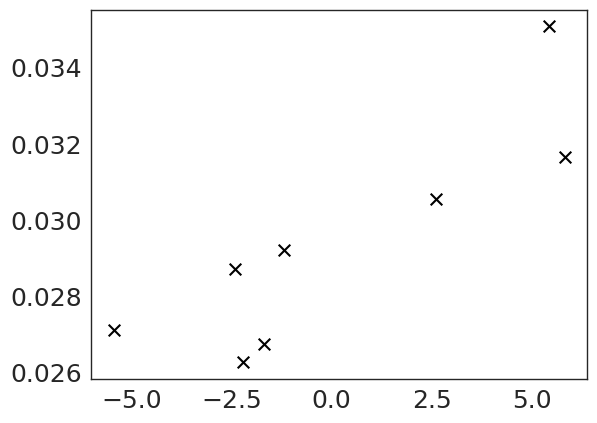

In [37]:
plt.scatter(
    data['z'], 
    data['prob'], 
    color='black', 
    marker='x', 
    edgecolors='black',  # Black edge color
    s=70,
    linewidths=1.5  # Thickness of the edge
)


In [81]:
better['log2_hr_abs'] = np.abs(better['log2_hr'])
barplotdf = better.query('motif in ["3_clique", "4_clique"]').sort_values(by='log2_hr_abs')[::-1].groupby('tissue').head(20)

In [97]:
tissuedf

interaction tissue        hr       hr1  \
87069     COL15A1+ITGA10_ITGB1&ACVR1_ACVR2A+BMP6   Skin  0.328148  0.723666   
47334                  CD4+HLA-DPA1&CLEC2B+KLRB1   Skin  0.326307  0.477509   
48060                       ICAM1+SPN&CD69+KLRB1   Skin  0.326142  0.411167   
55433                    ACKR1+CCL8&CXCL13+CXCR5   Skin  0.325368  0.538596   
81577  COL10A1+ITGA10_ITGB1&COL22A1+ITGA10_ITGB1   Skin  0.320463  0.730929   
40305                       CCL8+CCR5&CD69+KLRB1   Skin  0.318404  0.449089   
46616                     CCL8+CCR5&CXCL13+CXCR5   Skin  0.318369  0.449089   
52494            ENTPD1+P2RY13&TNFRSF11B+TNFSF11   Skin  0.318104  0.470345   
46231                     CCL8+CCR2&CXCL13+CXCR5   Skin  0.315785  0.444826   
62703           TNFRSF9+TNFSF9&ICAM1+ITGAX_ITGB2   Skin  0.315054  0.489934   
45287                     CCL8+CCR2&CLEC2B+KLRB1   Skin  0.312492  0.444826   
45130                  CXCL11+CXCR3&CLEC2B+KLRB1   Skin  0.306713  0.456853   
45276                  CXCL10+CXCR3&CLEC2B+KLRB1   Skin  0.306587  0.475679   
45334                   CD4+HLA-DOB&CLEC2B+KLRB1   Skin  0.302687  0.459719   
44528                  CXCL13+CXCR3&CLEC2B+KLRB1   Skin  0.302205  0.497478   
43677                     CCL8+CCR5&CLEC2B+KLRB1   Skin  0.302177  0.449089   
49515                  CXCL13+CXCR5&CLEC2B+KLRB1   Skin  0.294936  0.464798   
53669                 ICAM1+ITGB2&TNFRSF9+TNFSF9   Skin  0.287941  0.425812   
53538           ICAM1+ITGAL_ITGB2&TNFRSF9+TNFSF9   Skin  0.269946  0.390953   
52779           ICAM1+ITGAM_ITGB2&TNFRSF9+TNFSF9   Skin  0.267906  0.412562   

            hr2  concordance_index  concordance_index1  concordance_index2  \
87069  0.616316           0.645686            0.569136            0.563829   
47334  0.412307           0.640439            0.593589            0.615154   
48060  0.460580           0.638315            0.608015            0.597831   
55433  0.464798           0.646723            0.582358            0.606920   
81577  0.419845           0.667863            0.573930            0.617883   
40305  0.460580           0.651324            0.614568            0.597831   
46616  0.464798           0.662103            0.614568            0.606920   
52494  0.500857           0.650214            0.607869            0.584130   
46231  0.464798           0.655476            0.611561            0.606920   
62703  0.453601           0.646376            0.593133            0.599320   
45287  0.412307           0.644345            0.611561            0.615154   
45130  0.412307           0.650857            0.605494            0.615154   
45276  0.412307           0.653030            0.605051            0.615154   
45334  0.412307           0.648111            0.602813            0.615154   
44528  0.412307           0.652237            0.594078            0.615154   
43677  0.412307           0.654380            0.614568            0.615154   
49515  0.412307           0.657751            0.606920            0.615154   
53669  0.489934           0.653981            0.608282            0.593133   
53538  0.489934           0.660244            0.618699            0.593133   
52779  0.489934           0.665805            0.612236            0.593133   

       logrank_pval  logrank_pval1  ...  min_patients2   log2_hr  log2_hr1  \
87069  8.459609e-04   1.554582e-01  ...             97 -1.607583 -0.466604   
47334  2.242261e-08   7.815395e-07  ...            147 -1.615699 -1.066400   
48060  3.595442e-08   6.261645e-07  ...            188 -1.616428 -1.282204   
55433  1.354345e-06   5.288274e-04  ...            148 -1.619854 -0.892724   
81577  4.736189e-04   1.789539e-01  ...             72 -1.641770 -0.452197   
40305  1.106294e-10   9.724277e-08  ...            188 -1.651068 -1.154926   
46616  1.358333e-08   9.724277e-08  ...            148 -1.651226 -1.154926   
52494  3.961596e-07   3.185280e-06  ...            153 -1.652428 -1.088210   
46231  1.023464e-08   1.187162e-07  

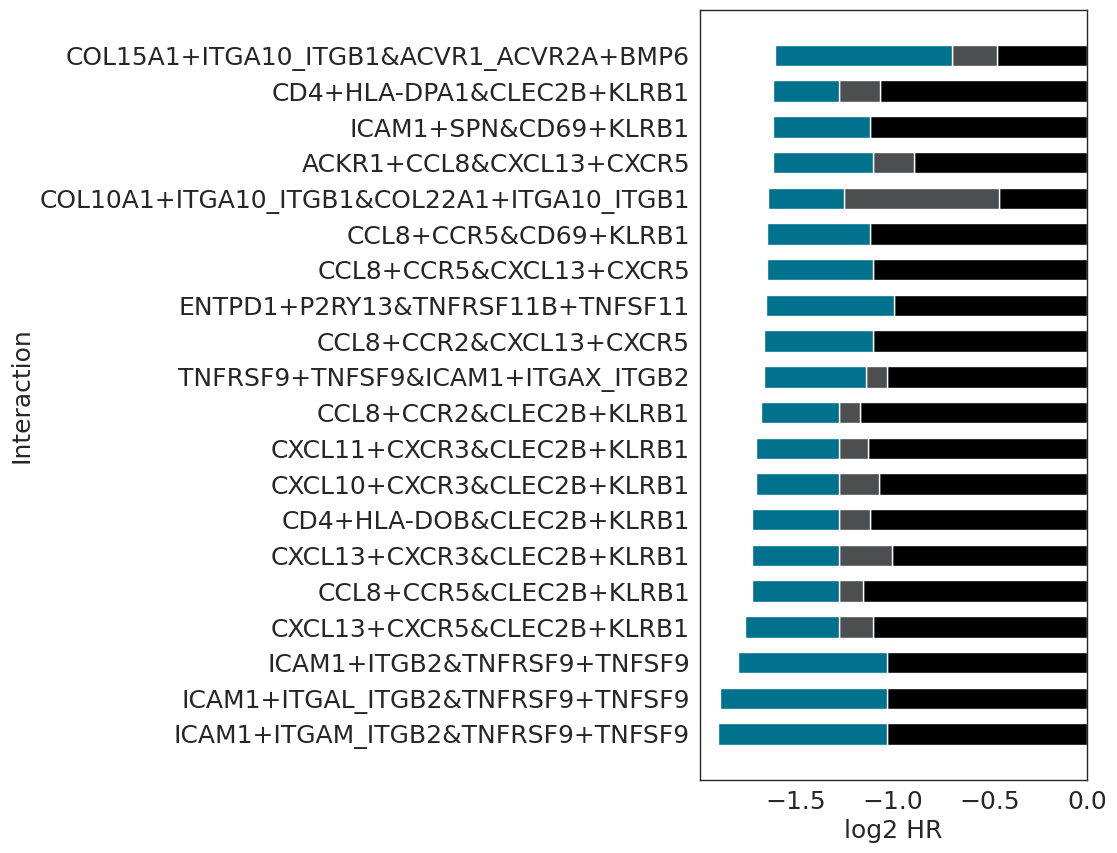

In [99]:
fig, ax = plt.subplots(1,1, figsize=(5,10))

# Sort and prepare data
tissuedf = barplotdf.query('tissue == "Skin"').sort_values(by='hr')[::-1]
y_pos = np.arange(len(tissuedf))

for j, (i, row) in enumerate(tissuedf.iterrows()):
    ypos = y_pos[j]
    
    hr1 = row['log2_hr1']
    hr2 = row['log2_hr2']
    hr = row['log2_hr']
    
    # First segment: from 0 to log2_hr1 (black)
    if hr1 != 0:
        ax.barh(ypos, hr1, color='k', height=0.6)
    
    # Second segment: from log2_hr1 to log2_hr2 (graycolor)
    width2 = hr2 - hr1
    if width2 != 0:
        ax.barh(ypos, width2, left=hr1, color=graycolor, height=0.6)
    
    # Third segment: from log2_hr2 to log2_hr (ncolor)
    width3 = hr - hr2
    if width3 != 0:
        ax.barh(ypos, width3, left=hr2, color=ncolor, height=0.6)

# Tidy up
ax.set_yticks(y_pos)
ax.set_yticklabels(tissuedf['interaction'])
ax.invert_yaxis()
ax.set_xlabel('log2 HR')
ax.set_ylabel('Interaction')
plt.tight_layout()
plt.show()


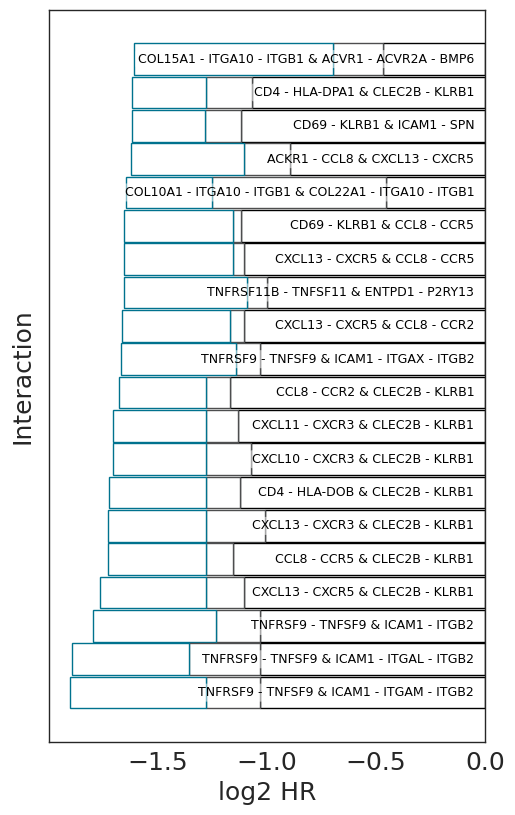

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))  # Keep the same width for the figure

# Sort and prepare data
tissuedf = barplotdf.query('tissue == "Skin"').sort_values(by='hr')[::-1]
y_pos = np.arange(len(tissuedf))

new_labels = []

for j, (i, row) in enumerate(tissuedf.iterrows()):
    ypos = y_pos[j]
    
    hr1 = row['log2_hr1']
    hr2 = row['log2_hr2']
    hr = row['log2_hr']
    interaction = row['interaction']
    
    # Split interaction by '&'
    part1, part2 = interaction.split('&')
    
    # Format parts: replace + and _ with ' - '
    part1_formatted = part1.replace('+', ' - ').replace('_', ' - ').strip()
    part2_formatted = part2.replace('+', ' - ').replace('_', ' - ').strip()
    
    # Decide order based on hr1 and hr2
    if abs(hr1) < abs(hr2):
        hr_black, hr_gray = hr1, hr2
        interaction_final = f"{part1_formatted} & {part2_formatted}"
    else:
        hr_black, hr_gray = hr2, hr1
        interaction_final = f"{part2_formatted} & {part1_formatted}"
    
    new_labels.append(interaction_final)
    
    # First segment: from 0 to hr_black (black)
    if hr_black != 0:
        ax.barh(ypos, hr_black, color='white', edgecolor='black', linewidth=height=0.95)  # Interior white, edge black
    
    # Second segment: from hr_black to hr_gray (graycolor)
    width2 = hr_gray - hr_black
    if width2 != 0:
        ax.barh(ypos, width2, left=hr_black, color='white', edgecolor=graycolor, height=0.95)  # Interior white, edge gray
    
    # Third segment: from hr_gray to hr (ncolor)
    width3 = hr - hr_gray
    if width3 != 0:
        ax.barh(ypos, width3, left=hr_gray, color='white', edgecolor=ncolor, height=0.95)  # Interior white, edge ncolor

    # Add interaction name inside the bar
    # Calculate mid-position for placing the text (aligned with 0)
    text_pos = -0.05  # Always place the text at the start of the bar
    
    # Add white background box with transparency and smaller padding
    ax.text(text_pos, ypos, interaction_final, va='center', ha='right', color='k', fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.5))

# Remove interaction names from ylabels
ax.set_yticklabels(['']*len(y_pos))

# Tidy up: remove whitespace and set the layout tighter
ax.set_yticks(y_pos)
ax.invert_yaxis()
ax.set_xlabel('log2 HR')
ax.set_ylabel('Interaction')

# Use tight_layout and adjust the margins to remove extra whitespace
plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)

plt.show()


# Survival Dotplot

In [13]:
pancancer_motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs.csv')
parentdir = '/home/lnemati/pathway_crosstalk/results/crosstalk/motifs_per_tissue/tumor/'
cliques = pd.DataFrame(columns=['motif', 'genes', 'module_original_label', 'module', 'subtissue'])

for dirs in os.listdir(parentdir):
    tissue_motifs = pd.read_csv(os.path.join(parentdir, dirs, 'motifs.csv'))
    tissue_motifs['subtissue'] = dirs
    
    tissue_cliques = tissue_motifs.query('motif in ["3_clique", "4_clique"]').set_index('interaction')
    pancancer_cliques = pancancer_motifs.query('Type in ["3_clique", "4_clique"]').set_index('Interaction')

    intersection = pancancer_cliques.index.intersection(tissue_cliques.index)
    tissue_cliques = tissue_cliques.loc[intersection]
    
    cliques = pd.concat([cliques, tissue_cliques])
    
cliques.index.name = 'interaction'

# Add major tissue information
tissuesdf = pd.read_csv('/home/lnemati/pathway_crosstalk/data/tissues.csv')
cliques['tissue'] = cliques.subtissue.map(tissuesdf.set_index('subtissue')['tissue'])

# Read survival results
crosstalkdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_pairs.csv')

significant = crosstalkdf.query('pval_adj < 0.05')
significant = significant.query('not ((hr - se) < 1 and 1 < (hr + se))')

# Merge survival information with cliques df
crosstalkdf['tissue'] = crosstalkdf['tissue'].str.lower()
crosstalkdf = crosstalkdf.set_index(['interaction', 'tissue'])

cliques = cliques.reset_index(drop=False)
cliques = cliques.set_index(['interaction', 'tissue'])

In [14]:
# Get top interaction per module

modules = cliques[['module', 'subtissue']].join(crosstalkdf)

better = modules.query('pval_adj < 0.05').copy()
better = better.query('hr_lfc_best > 0.')
better = better.query('c_diff_best > 0.')
better = better.query('(logrank_pval < logrank_pval1) and (logrank_pval < logrank_pval2)')

#modules = modules.dropna().sort_values(by='hr_lfc_best', ascending=False)
better = better.dropna().sort_values(by='logrank_pval')
better = better.dropna().sort_values(by='concordance_index', ascending=False)

#interactions = better.groupby(['module', 'subtissue']).head(1).index.get_level_values(0)
interactions = better.groupby(['subtissue']).head(3).index.get_level_values(0)
interactions = np.unique(interactions)

In [15]:
filtered = crosstalkdf.loc[interactions]
filtered['-log10(p_adj)'] = -np.log10(filtered['pval_adj'].astype(float))
filtered['-log10(p_adj)'] = filtered['-log10(p_adj)'].clip(0, 15)
filtered = filtered.reset_index(drop=False)

value = 'log2_hr'

# Find better
better = filtered.copy()
#better = better.query('pval_adj < 0.05').copy()
better = better.query('hr_lfc_best > 0.')
better = better.query('c_diff_best > 0.')
better = better.query('(logrank_pval < logrank_pval1) and (logrank_pval < logrank_pval2)')
filtered['is_better'] = False
filtered.loc[better.index, 'is_better'] = True

# Find significant
significant = filtered.copy()
significant = significant.query('pval_adj < 0.05').copy()

filtered['is_significant'] = False
filtered.loc[significant.index, 'is_significant'] = True

filtered['interaction'] = filtered['interaction'].str.replace('+', ' - ').str.replace('_', ' - ').str.replace('&', ' & ')

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist

# Compute pairwise distances and hierarchical clustering
interaction_matrix = filtered.pivot(index="interaction", columns="tissue", values=value).fillna(0)
row_linkage = linkage(pdist(interaction_matrix, metric='euclidean'), method='ward')
col_linkage = linkage(pdist(interaction_matrix.T, metric='euclidean'), method='ward')

# Get the clustered order
interaction_order = interaction_matrix.index[leaves_list(row_linkage)]
tissue_order = interaction_matrix.columns[leaves_list(col_linkage)]

# Reorder the dataframe
filtered['interaction'] = pd.Categorical(filtered['interaction'], categories=interaction_order, ordered=True)
filtered['tissue'] = pd.Categorical(filtered['tissue'], categories=tissue_order, ordered=True)
filtered = filtered.sort_values(['interaction', 'tissue'])

# Remove pancancer
filtered = filtered.query('tissue != "pan_cancer"')

filtered['tissue'] = filtered['tissue'].str.replace('_', ' ').str.title()

# Only show tissues with significant entries
tissues_keep = filtered.query('is_significant')['tissue'].unique()
filtered = filtered.query('tissue in @tissues_keep')

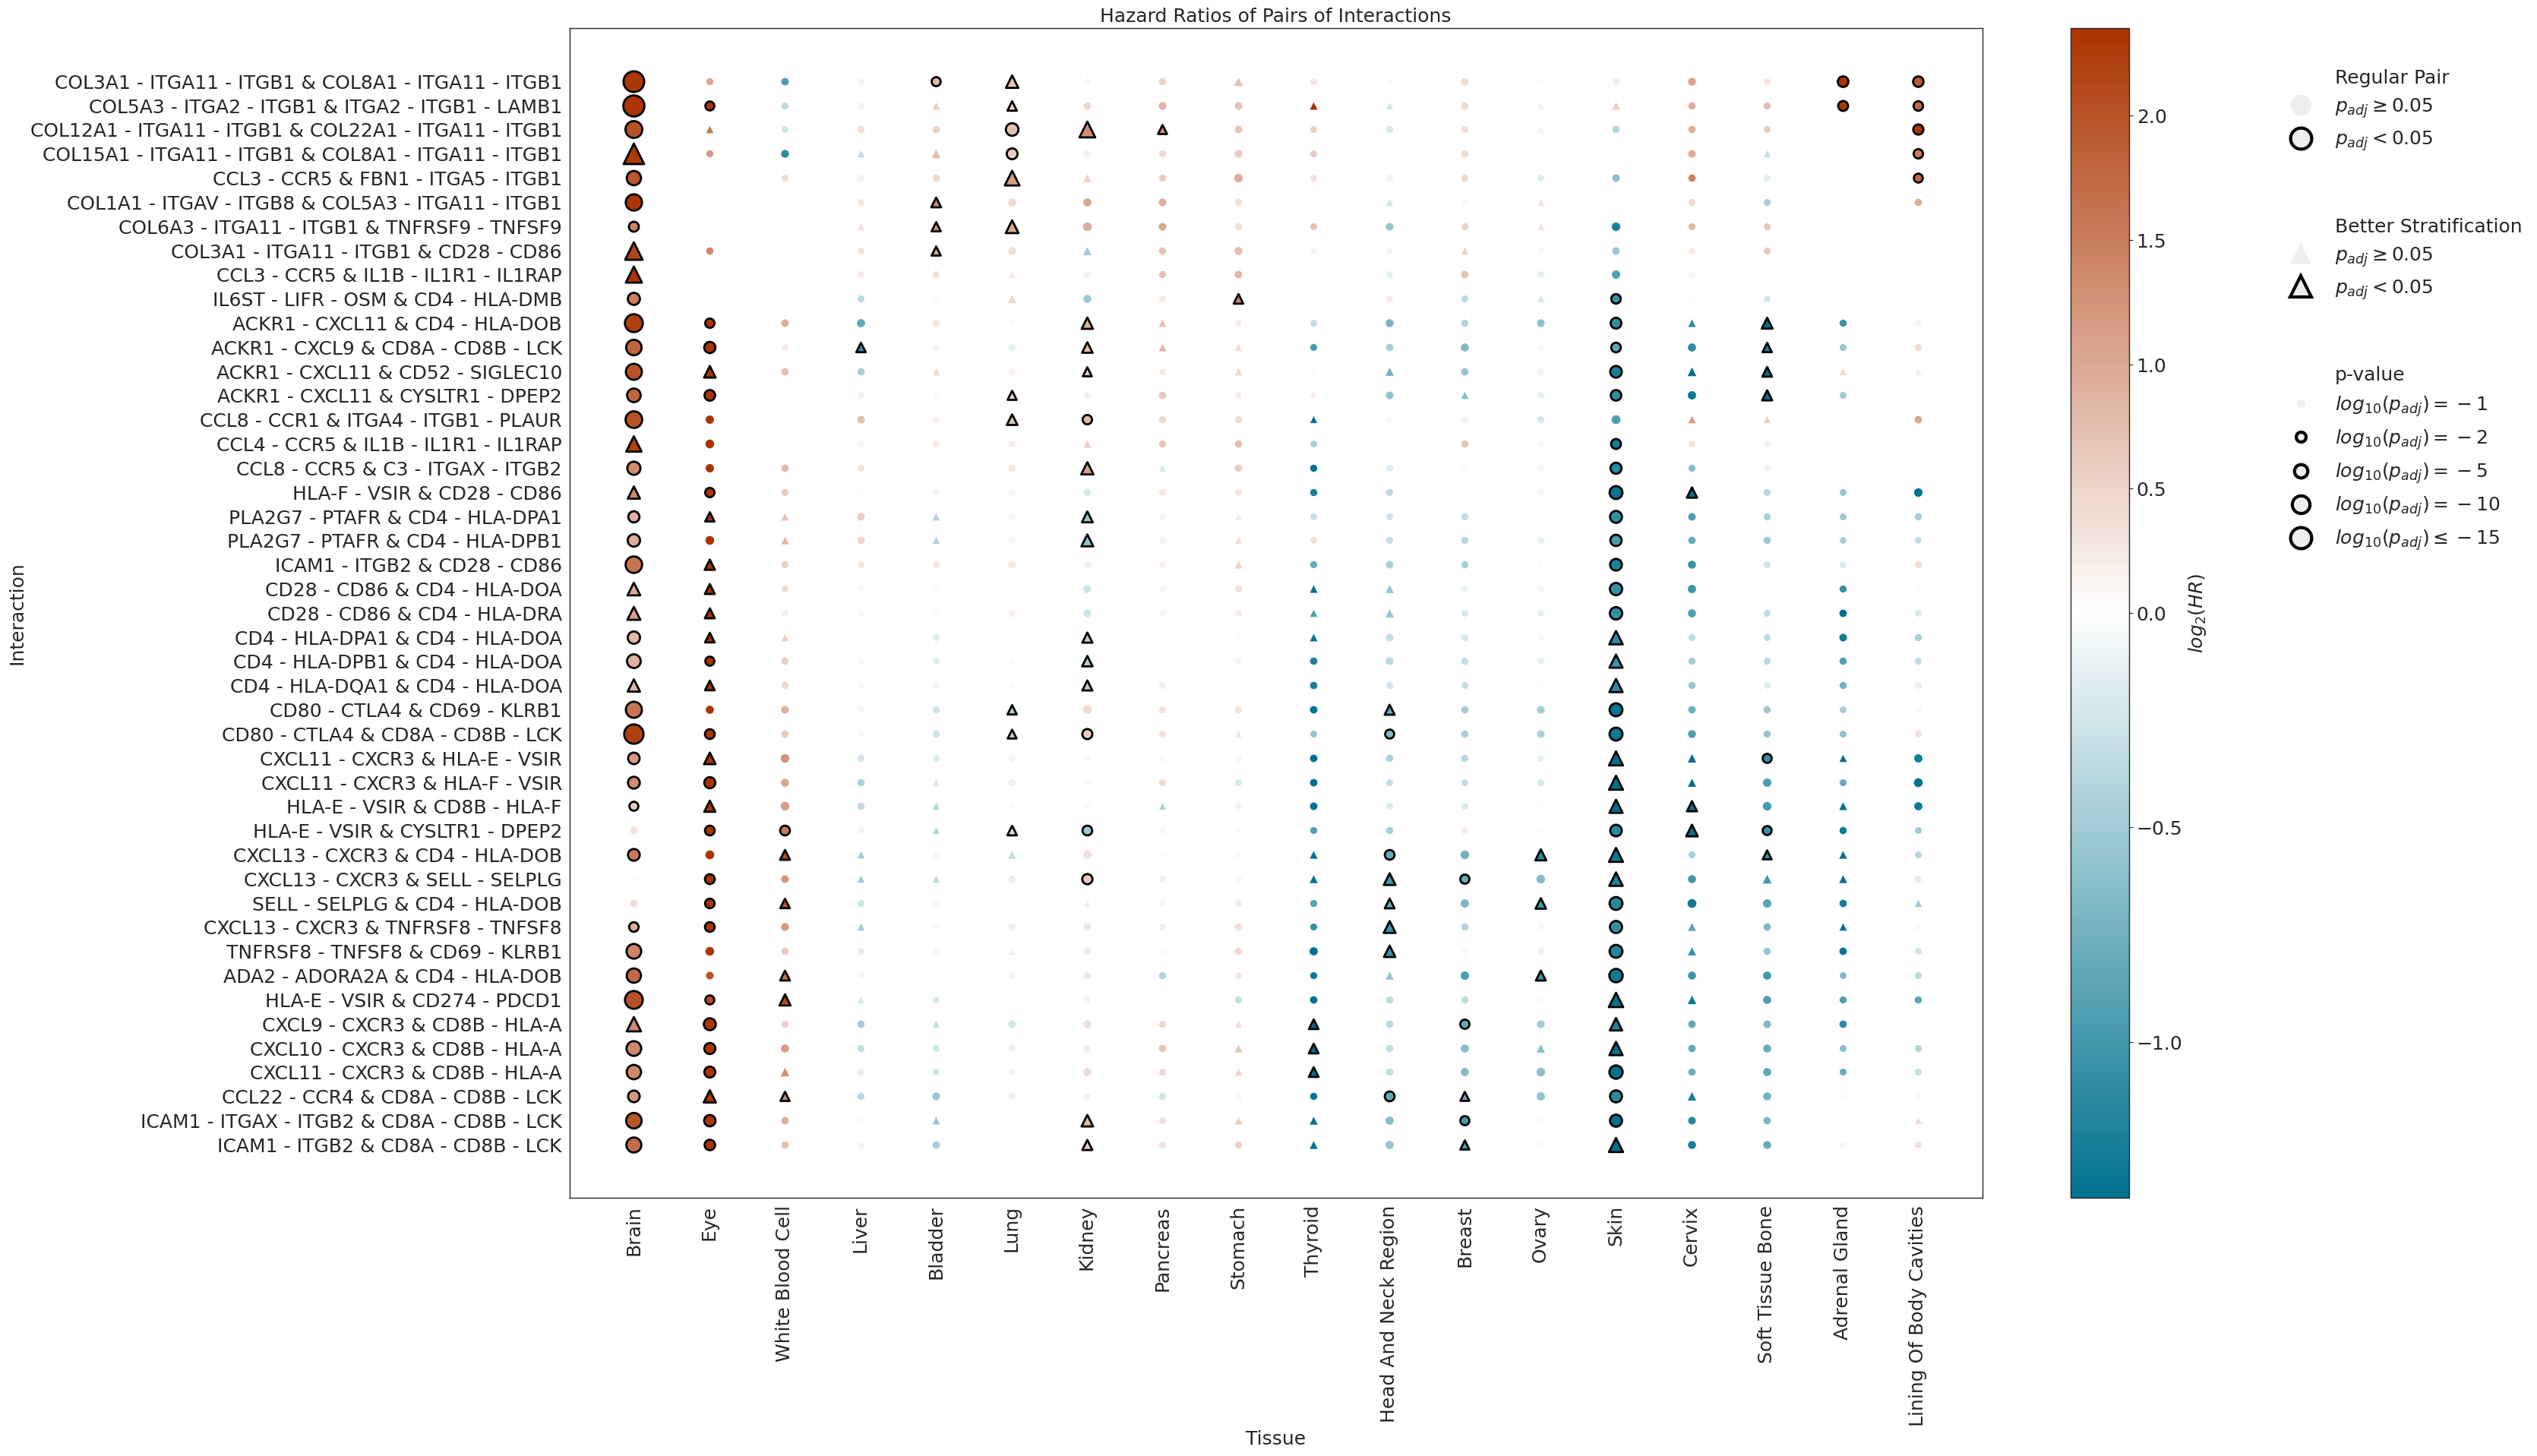

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm

# Set global font size
fs = 18

plt.rcParams.update({'font.size': fs})

# Define custom colormap
colors = [ncolor, 'white', tcolor]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
norm = TwoSlopeNorm(vmin=filtered[value].quantile(0.05), vcenter=0, vmax=filtered[value].quantile(0.95))
#norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)

# Create the scatter plot
plt.figure(figsize=(30, 20))

# Calculate size scaling
sizes = (40, 400)
size_min, size_max = sizes
factor = (size_max - size_min) / (filtered['-log10(p_adj)'].max() - filtered['-log10(p_adj)'].min())

# Plot empty scatterplot
scatter = sns.scatterplot(
    data=filtered,
    x="tissue",
    y="interaction",
    size=1e-6,
    hue_norm=norm,
    color='white',
    sizes=sizes,
    linewidth=0
)

for _, row in filtered.iterrows():
    # Compute the size dynamically based on -log10(p_adj)
    point_size = size_min + (row['-log10(p_adj)'] - filtered['-log10(p_adj)'].min()) * factor
    
    # Define marker shape and color
    marker = '^' if row['is_better'] else 'o'
    lw = 2 if row['is_significant'] else 0
    color = custom_cmap(norm(row['log2_hr']))
        
    plt.scatter(
        x=row['tissue'],
        y=row['interaction'],
        marker=marker,
        s=point_size,
        edgecolor='k',
        facecolor=color,
        linewidth=lw
    )

# Add colorbar with fontsize
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), label='$log_2(HR)$')
cbar.ax.tick_params(labelsize=fs)  # Set colorbar tick fontsize
cbar.set_label('$log_2(HR)$', fontsize=fs)  # Set colorbar label fontsize

plt.xticks(rotation=90, fontsize=fs)
plt.yticks(fontsize=fs)

# Customize the first 5 y-axis labels to make them bold
ax = plt.gca()
y_labels = ax.get_yticklabels()

# Modify labels
for label in y_labels:
    if label._text in cliques:
        label.set_fontweight('bold')
ax.set_yticklabels(y_labels, fontsize=fs)

# Custom legend
legend_elements = [
    mpatches.Patch(color='none', label="Regular Pair"),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='o', linestyle='None', markersize=20, markeredgewidth=0., label='$p_{adj} \geq 0.05$'),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='o', linestyle='None', markersize=20, markeredgewidth=3, label='$p_{adj} < 0.05$'),
    mpatches.Patch(color='none', label=""),
    mpatches.Patch(color='none', label=""),


    mpatches.Patch(color='none', label="Better Stratification"),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='^', linestyle='None', markersize=20, markeredgewidth=0., label='$p_{adj} \geq 0.05$'),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='^', linestyle='None', markersize=20, markeredgewidth=3, label='$p_{adj} < 0.05$'),
    mpatches.Patch(color='none', label=""),
    mpatches.Patch(color='none', label=""),

    # Section for size explanation
    mpatches.Patch(color='none', label='p-value'),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='o', markersize=(size_min + (1 - filtered['-log10(p_adj)'].min()) * factor)**0.5, linestyle='None', markeredgewidth=0,  label='$log_{10}(p_{adj}) = -1$'),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='o', markersize=(size_min + (2 - filtered['-log10(p_adj)'].min()) * factor)**0.5, linestyle='None', markeredgewidth=3,  label='$log_{10}(p_{adj}) = -2$'),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='o', markersize=(size_min + (5 - filtered['-log10(p_adj)'].min()) * factor)**0.5, linestyle='None', markeredgewidth=3,  label='$log_{10}(p_{adj}) = -5$'),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='o', markersize=(size_min + (10 - filtered['-log10(p_adj)'].min()) * factor)**0.5, linestyle='None', markeredgewidth=3, label='$log_{10}(p_{adj}) = -10$'),
    mlines.Line2D([], [], mfc='#eeeeee', mec='k', marker='o', markersize=(size_min + (15 - filtered['-log10(p_adj)'].min()) * factor)**0.5, linestyle='None', markeredgewidth=3, label='$log_{10}(p_{adj}) \leq -15$'),

]

# Adjust legend
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.2, 0.98), fontsize=fs, frameon=False)

plt.title("Hazard Ratios of Pairs of Interactions", fontsize=fs)
plt.xlabel("Tissue", fontsize=fs)
plt.ylabel("Interaction", fontsize=fs)

plt.show()


In [18]:
better.

interaction                   tissue        hr       hr1  \
2      ACKR1+CXCL11&CD4+HLA-DOB                   kidney  1.819167  1.365898   
3      ACKR1+CXCL11&CD4+HLA-DOB         soft_tissue_bone  0.298208  0.445946   
9      ACKR1+CXCL11&CD4+HLA-DOB                   cervix  0.468086  0.591502   
11     ACKR1+CXCL11&CD4+HLA-DOB                 pancreas  1.684585  1.439009   
15     ACKR1+CXCL11&CD4+HLA-DOB                    colon  1.290027  1.078893   
...                         ...                      ...       ...       ...   
1081    SELL+SELPLG&CD4+HLA-DOB  lining_of_body_cavities  0.694427  0.874666   
1097  TNFRSF8+TNFSF8&CD69+KLRB1     head_and_neck_region  0.491237  0.616727   
1100  TNFRSF8+TNFSF8&CD69+KLRB1                   cervix  0.479467  0.627531   
1103  TNFRSF8+TNFSF8&CD69+KLRB1                     lung  1.150347  1.062262   
1104  TNFRSF8+TNFSF8&CD69+KLRB1              endometrium  0.473968  0.753159   

           hr2  concordance_index  concordance_index1  concordance_index2  \
2     1.107589           0.536377            0.512050            0.502380   
3     0.573061           0.682174            0.638693            0.590725   
9     0.686611           0.640063            0.603182            0.581439   
11    1.072603           0.543510            0.533810            0.484986   
15    1.019291           0.532429            0.517739            0.487649   
...        ...                ...                 ...                 ...   
1081  0.764110           0.559946            0.532209            0.547688   
1097  0.664453           0.599628            0.560949            0.548011   
1100  0.609410           0.642648            0.593966            0.607676   
1103  0.925290           0.517630            0.505042            0.514343   
1104  0.613426           0.631579            0.525573            0.566887   

      logrank_pval  logrank_pval1  ...  min_patients1  min_patients2  \
2         0.000060       0.011307  ...           1080           1140   
3         0.000171       0.002298  ...             80             92   
9         0.065966       0.106718  ...             81            107   
11        0.118331       0.203719  ...             50             62   
15        0.465952       0.811437  ...             87            125   
...            ...            ...  ...            ...            ...   
1081      0.286659       0.651834  ...             27             28   
1097      0.000053       0.000939  ...            198            207   
1100      0.031848       0.085850  ...            108            115   
1103      0.136532       0.452353  ...            800            898   
1104      0.160596       0.464858  ...             65             62   

       log2_hr  log2_hr1  log2_hr2  pval_adj  hr_lfc_best  c_diff_best  \
2     0.863278  0.449850  0.147423  0.000703     0.413428     0.024327   
3    -1.745609 -1.165058 -0.803239  0.001851     0.580551     0.043481   
9    -1.095154 -0.757544 -0.542436  0.261851     0.337610     0.036881   
11    0.752393  0.525076  0.101116  0.384398     0.227317     0.009701   
15    0.367401  0.109552  0.027566  0.789906     0.257849     0.014690   
...        ...       ...       ...       ...          ...          ...   
1081 -0.526106 -0.193196 -0.388148  0.634684     0.137958     0.012258   
1097 -1.025509 -0.697295 -0.589760  0.000623     0.328214     0.038678   
1100 -1.060497 -0.672242 -0.714515  0.155820     0.345983     0.034972   
1103  0.202069  0.087140 -0.112022  0.419900     0.090047     0.003287   
1104 -1.077138 -0.408973 -0.705039  0.462628     0.372100     0.064692   

         motif  -log10(p_adj)  
2     4_clique       3.152852  
3     4_clique       2.732595  
9     4_clique       0.581945  
11    4_clique       0.415218  
15    4_clique       0.102425  
...        ...            ...  
1081  4_clique       0.197442  
1097  4_clique       3.205816  
1100  4_clique       0.807377  
1103  4_clique       0.376854  
1104  4_clique       0.33476

# Cliques Survival

In [242]:
rawdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_unfiltered.csv')
crosstalkdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_pairs.csv')

significant = crosstalkdf.query('pval_adj < 0.05')
significant = significant.query('not ((hr - se) < 1 and 1 < (hr + se))')

better = significant.copy()
better = better.query('hr_lfc_best > 0.')
better = better.query('c_diff_best > 0.')
better = better.query('(logrank_pval < logrank_pval1) and (logrank_pval < logrank_pval2)')

#better = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/better_pairs.csv')
better.head(3)

interaction      tissue        hr       hr1       hr2  \
0     ADA+ADORA2B&FBN1+ITGA5_ITGB1  Pan_Cancer  2.473422  1.449832  1.453431   
1  COL6A3+ITGA10_ITGB1&ADA+ADORA2B  Pan_Cancer  2.690729  1.434415  1.449832   
2     FN1+ITGA11_ITGB1&ADA+ADORA2B  Pan_Cancer  2.452652  1.395628  1.449832   

   concordance_index  concordance_index1  concordance_index2   logrank_pval  \
0           0.525176            0.520904            0.522021  1.996489e-290   
1           0.522922            0.516268            0.520904  2.855622e-255   
2           0.526302            0.520509            0.520904  1.348607e-251   

   logrank_pval1  ...  min_patients  min_patients1  min_patients2   log2_hr  \
0  2.866094e-192  ...         46629         112035         101772  1.306508   
1  2.507191e-171  ...         29337          76494         112035  1.427997   
2  3.625836e-201  ...         37092          93621         112035  1.294343   

   log2_hr1  log2_hr2       pval_adj  hr_lfc_best  c_diff_best           motif  
0  0.535886  0.539462  1.599185e-284     0.767046     0.003155          4_path  
1  0.520463  0.535886  1.143675e-249     0.892112     0.002018  4_no_crosstalk  
2  0.480914  0.535886  3.600776e-246     0.758457     0.005398  4_no_crosstalk  

[3 rows x 30 columns]

In [243]:
def survival(interactions, df):
    import pandas as pd
    from lifelines import KaplanMeierFitter
    import re   
    
    df = df.copy()
    
    # Extract genes from the interaction string
    genes = list(set(re.split(r'[+&_]', interactions)))

    # Check if there are multiple conditions
    multiple_conditions = len(df['condition'].unique()) > 1

    # Filter and process the DataFrame
    cols = ['OS.time', 'OS', 'condition'] + genes
    df = df[cols]

    # Convert columns to numeric, except for condition
    df.loc[:, [col for col in df.columns if col != 'condition']] = (
        df.loc[:, [col for col in df.columns if col != 'condition']].apply(pd.to_numeric, errors='coerce')
    )
    df = df.dropna()

    # Convert OS time to years
    df['OS.time'] = df['OS.time'] / 365

    high_expression_group = pd.DataFrame()
    low_expression_group = pd.DataFrame()

    if multiple_conditions:
        # If there are multiple conditions, split the patients based on each condition
        for condition in df['condition'].unique():
            condition_df = df[df['condition'] == condition]
            
            # Calculate medians for each gene within the condition
            medians = condition_df[genes].median()
            
            # Identify patients above/below the median for all genes
            high_expression = condition_df[(condition_df[genes] > medians).T.all()]
            low_expression = condition_df[(condition_df[genes] <= medians).T.all()]
            
            # Append to the respective groups
            high_expression_group = pd.concat([high_expression_group, high_expression])
            low_expression_group = pd.concat([low_expression_group, low_expression])
    else:
        # If there is only one condition, split based on the entire dataset
        medians = df[genes].median()
        high_expression_group = df[(df[genes] > medians).T.all()]
        low_expression_group = df[(df[genes] <= medians).T.all()]

    # Remove patients that are in both groups
    common_patients = high_expression_group.index.intersection(low_expression_group)
    high_expression_group = high_expression_group[~high_expression_group.index.isin(common_patients)]
    low_expression_group  = low_expression_group[ ~low_expression_group.index.isin( common_patients)]
        
    # Count number of patients
    n_patients_low = low_expression_group.shape[0]
    n_patients_high = high_expression_group.shape[0]

    # Fit the Kaplan-Meier estimators
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(
        low_expression_group['OS.time'],
        event_observed=low_expression_group['OS'],
        label="Low Expression"
    )
    kmf_high.fit(
        high_expression_group['OS.time'],
        event_observed=high_expression_group['OS'],
        label="High Expression"
    )

    return {
        'name': interactions,
        'kmf_low': kmf_low,
        'kmf_high': kmf_high,
        'low_expression': low_expression_group.index,
        'high_expression': high_expression_group.index,
    }

In [271]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import matplotlib.patheffects as path_effects  # Import PathEffects for text outlines

def get_genes(string):
    genes = list(re.split(r'[+&_]', string))

    # Remove duplicates while preserving order
    seen = set()
    ordered_genes = []
    for gene in genes:
        if gene not in seen:
            seen.add(gene)
            ordered_genes.append(gene)

    return ordered_genes

def plot_all_3(interaction, tissue, survival_df, xlim=(0, 15), ylim=(0, 1.01), savepath=None, show=True):
    
    df = survival_df.copy()
    # Change index from samples to patients
    df.index = df.index.str.rsplit(pat='-', n=1, expand=True).get_level_values(0) 
        
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    interaction_results = survival(interaction, df)
    
    int1, int2 = interaction.split('&')
    interaction_results1 = survival(int1, df)
    interaction_results2 = survival(int2, df)

    fs = 13
    
    # Plot the KM curves for both groups on the same plot
    for ax, result in zip(axes, (interaction_results, interaction_results1, interaction_results2)):
        name = result['name']
        genes = get_genes(name)
        
        pval = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'logrank_pval']
        n_low = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_low']
        n_high = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_high']
        #pval = result['p_value']
                
        ci = False
        censors=True
        result['kmf_low'].plot_survival_function(
            ax=ax[1],
            color=ncolor,
            ci_show=ci,
            show_censors=censors,
            label='Low Expression, N={}'.format(n_low)
        )
        result['kmf_high'].plot_survival_function(
            ax=ax[1],
            color=tcolor,
            ci_show=ci,
            show_censors=censors,
            label='High Expression, N={}'.format(n_high)

        )
        add_at_risk_counts(result['kmf_low'], result['kmf_high'], ax=ax[1], ypos=-0.35, rows_to_show=['At risk'])
        
        ax[0].set_title(name, fontsize=fs)
        ax[1].set_title(name, fontsize=fs)
        
        ax[1].set_xlabel('Time (Years)', fontsize=fs)
        ax[1].set_ylabel('Survival Prob.', fontsize=fs)
        
        ax[1].set_xlim(xlim[0], xlim[1])
        ax[1].set_ylim(ylim[0], ylim[1])
        
        ax[1].legend(fontsize=fs, framealpha=0.5, loc='upper right')
        
        ypos = ax[1].get_ylim()[0] + 0.06*(ax[1].get_ylim()[1] - ax[1].get_ylim()[0])
        xpos = ax[1].get_xlim()[0] + 0.015*(ax[1].get_xlim()[1] - ax[1].get_xlim()[0])

        text = ax[1].text(xpos, ypos, '$p={:.1e}$'.format(pval), fontsize=0.8*fs)
        text.set_path_effects([
            path_effects.Stroke(linewidth=8, foreground=(1,1,1,0.5)),  # White outline
            path_effects.Normal()  # Normal text
        ])
        
        df['Group'] = None
        df.loc[df.index.isin(result['high_expression']), 'Group'] = 'High Expression'
        df.loc[df.index.isin(result['low_expression']), 'Group'] = 'Low Expression'
        violindata = df.melt(id_vars=['Group'], value_vars=genes)

        # Reorder violindata based on the genes list
        violindata['variable'] = pd.Categorical(violindata['variable'], categories=genes, ordered=True)

        # Create violin plot with explicit order
        sns.violinplot(
            data=violindata,
            x='variable',
            y='value',
            hue='Group',
            ax=ax[0],
            palette={'High Expression': tcolor, 'Low Expression': ncolor},
            order=genes,
            inner=None,
            cut=0
        )

        # Define the offset for the median line
        x_offset = 0.4
        lw = 2  # linewidth
        color = 'k'  # line color
        ls = '-'  # line style

        # Compute medians, preserving the order in genes
        median_values = (
            violindata.groupby('variable')['value'].median()
            .reindex(genes)  # Reorder by genes list
            .reset_index()
        )

        # Loop to add median lines with offset and collect coordinates
        #for i, (gene, median) in enumerate(zip(median_values['variable'], median_values['value'])):
        #    # Collect coordinates for the horizontal line (hlines)
        #        ax[0].plot([i - x_offset, i + x_offset], [median, median], color=color, linestyle=ls, linewidth=lw)

        #ax[0].set_xlim(-x_offset, len(genes)-1+x_offset)
        #ax[0].legend([])
        ax[0].set_xlabel('Gene', fontsize=fs)
        ax[0].set_ylabel('log2(0.001 + TPM)', fontsize=fs)
        ax[0].get_legend().remove()
        
        ax[0].tick_params(labelsize=fs)
        ax[1].tick_params(labelsize=fs)
        
        ax[0].spines[['bottom', 'left']].set_color('black')
        ax[0].spines[['right', 'top']].set_visible(False)
        ax[1].spines[['bottom', 'left']].set_color('black')
        ax[1].spines[['right', 'top']].set_visible(False)

    if savepath is not None:
        plt.savefig(savepath+'.pdf', bbox_inches='tight')
        plt.savefig(savepath+'.png', bbox_inches='tight')
    
    if show == True:
        plt.show()
    
    plt.clf()
    return
    
#interaction = 'CD4+IL16&BDNF+NGFR'
#urvival_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/survival_data/kidney.csv', index_col=0)
#plot_all_3('COL6A3+ITGA2_ITGB1&PLXNA1+SEMA5B', survival_df)

In [272]:
subset = better.query('motif in ["3_clique", "4_clique"] and min_patients >= 50')
subset = subset.query('logrank_pval1 > 0.01 and logrank_pval2 > 0.01')
subset = subset.query('hr_lfc_best > 0.58 and concordance_index > 0.5')
subset = subset.query('not ((hr - se) < 1 and (hr + se) > 1)')

subset.loc[subset['tissue'] == 'Thyroid_Gland', 'tissue'] = 'Thyroid'

In [273]:
subset = subset.sort_values(by='c_diff_best', ascending=False)
subset['c_rank'] = range(subset.shape[0])
subset = subset.sort_values(by='hr_lfc_best', ascending=False)
subset['hr_rank'] = range(subset.shape[0])
subset['rank'] = subset['c_rank'] + subset['hr_rank']
subset = subset.sort_values(by='rank')

subset['sign'] = subset['log2_hr'] > 0
to_plot =  subset.groupby(['tissue', 'sign']).head(3)
to_plot = to_plot.sort_values(by='tissue')


Bladder
TNFRSF9+TNFSF9&FN1+ITGA2_ITGB1


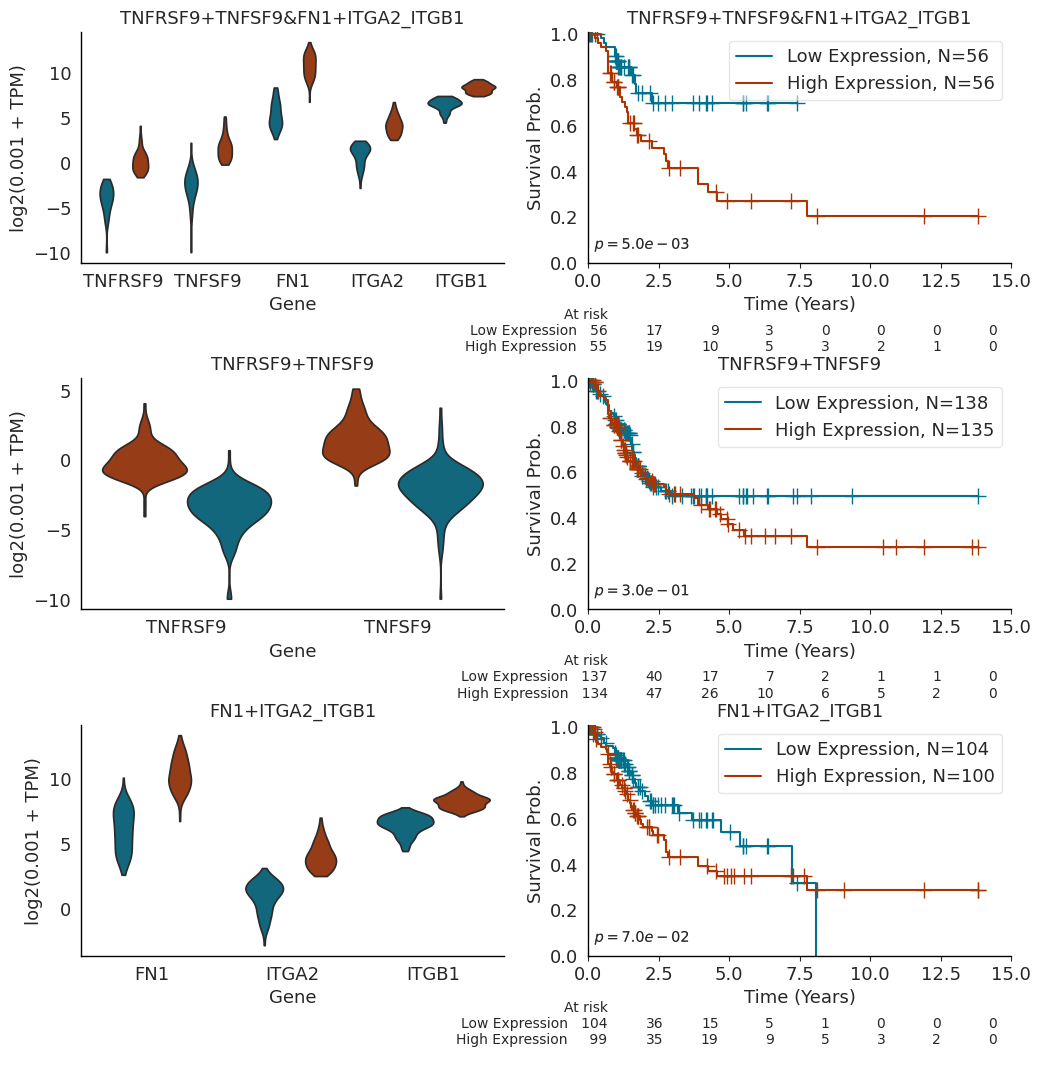

TNFRSF11B+TNFSF11&COL6A3+ITGA2_ITGB1


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

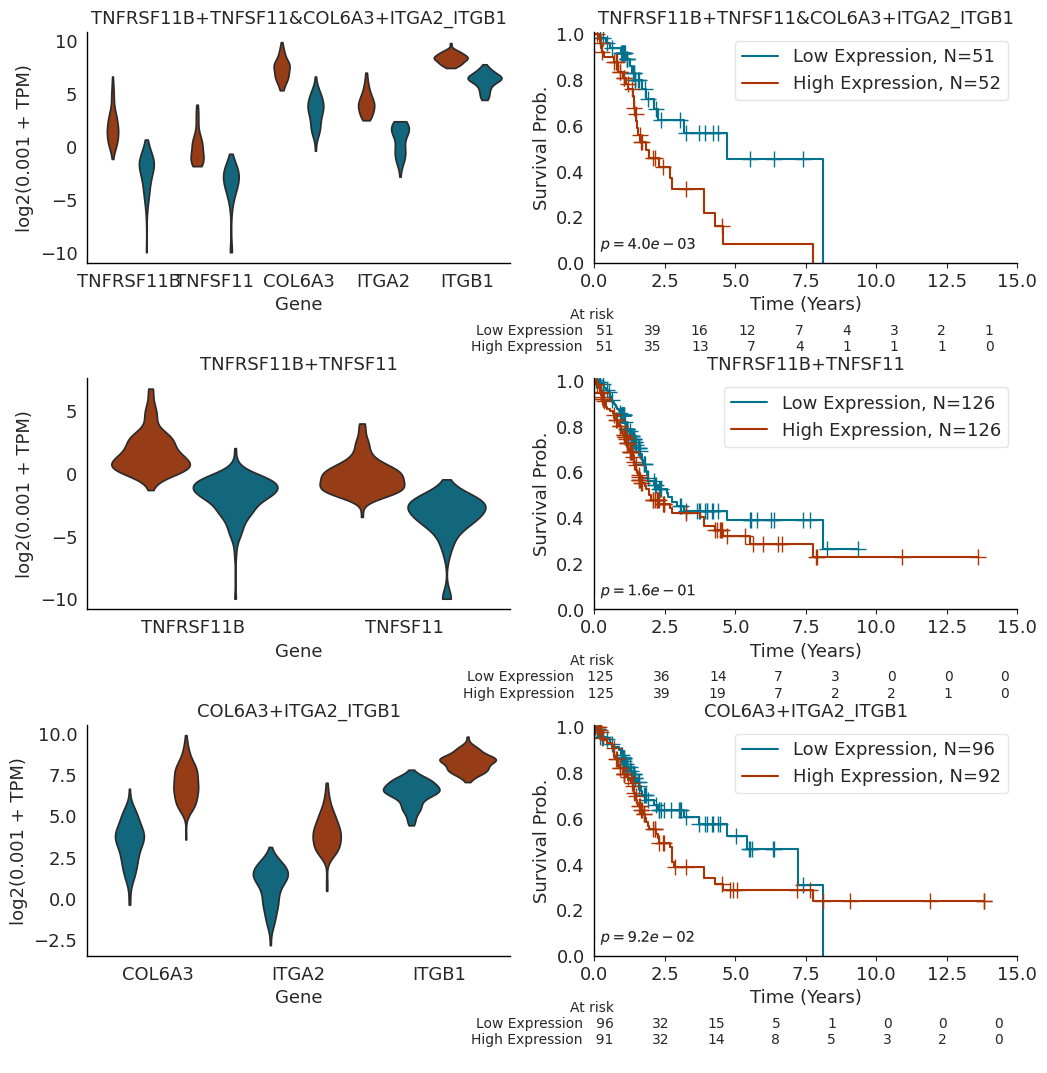

TNFRSF9+TNFSF9&PDGFB+PDGFRA_PDGFRB


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

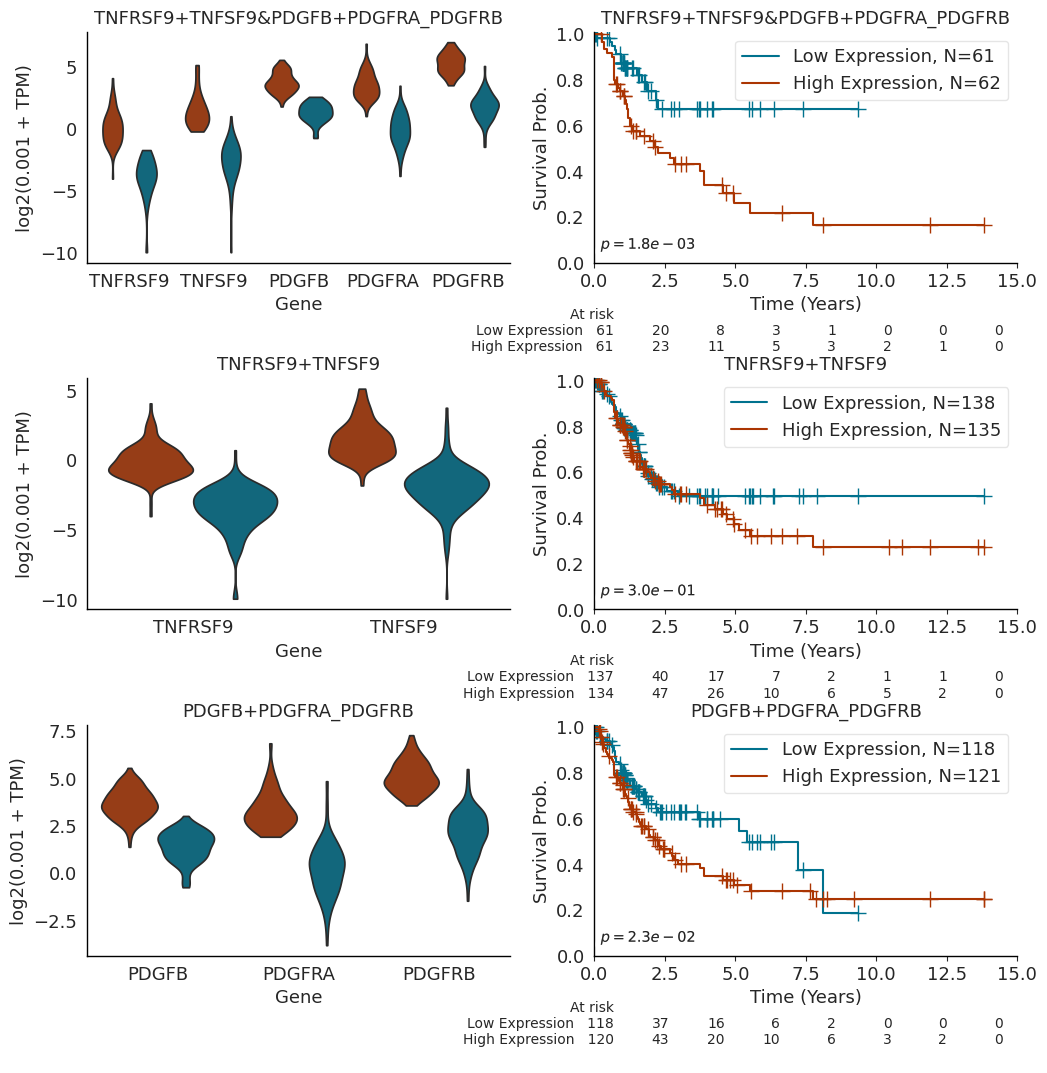

PLA2G7+PTAFR&HCST_KLRK1+MICA


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

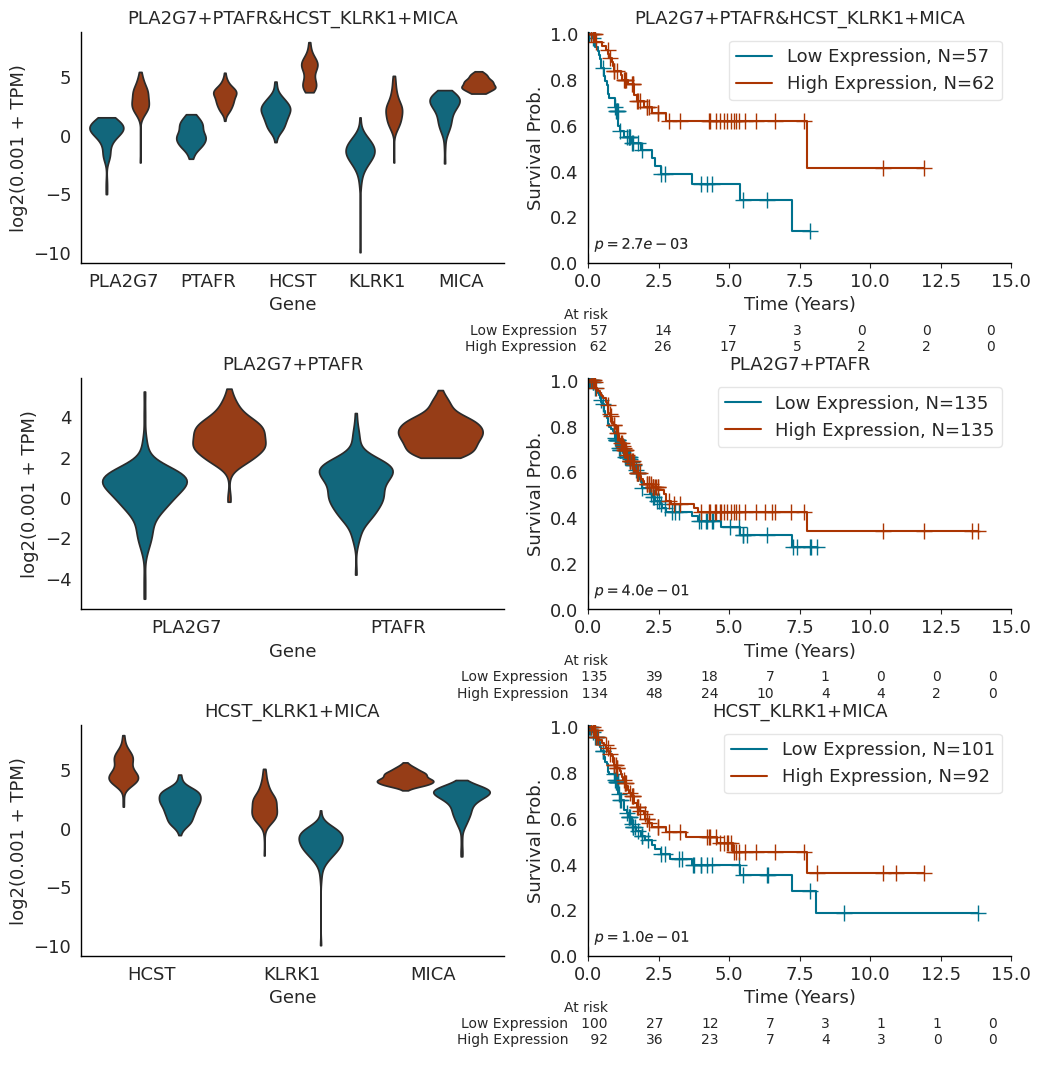




Brain
SELL+SELPLG&CX3CL1+CX3CR1


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

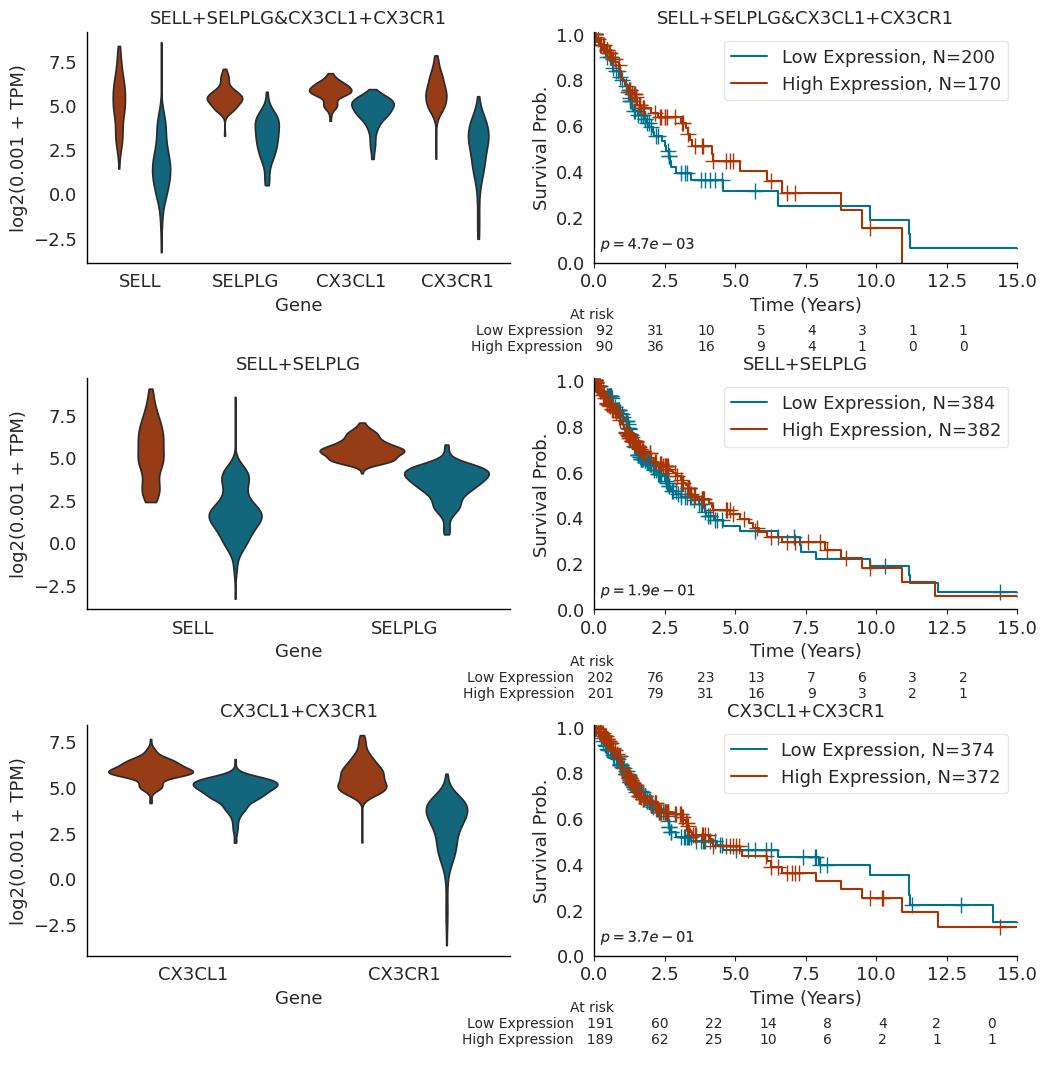

ACKR1+CCL18&CYSLTR1+DPEP2


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

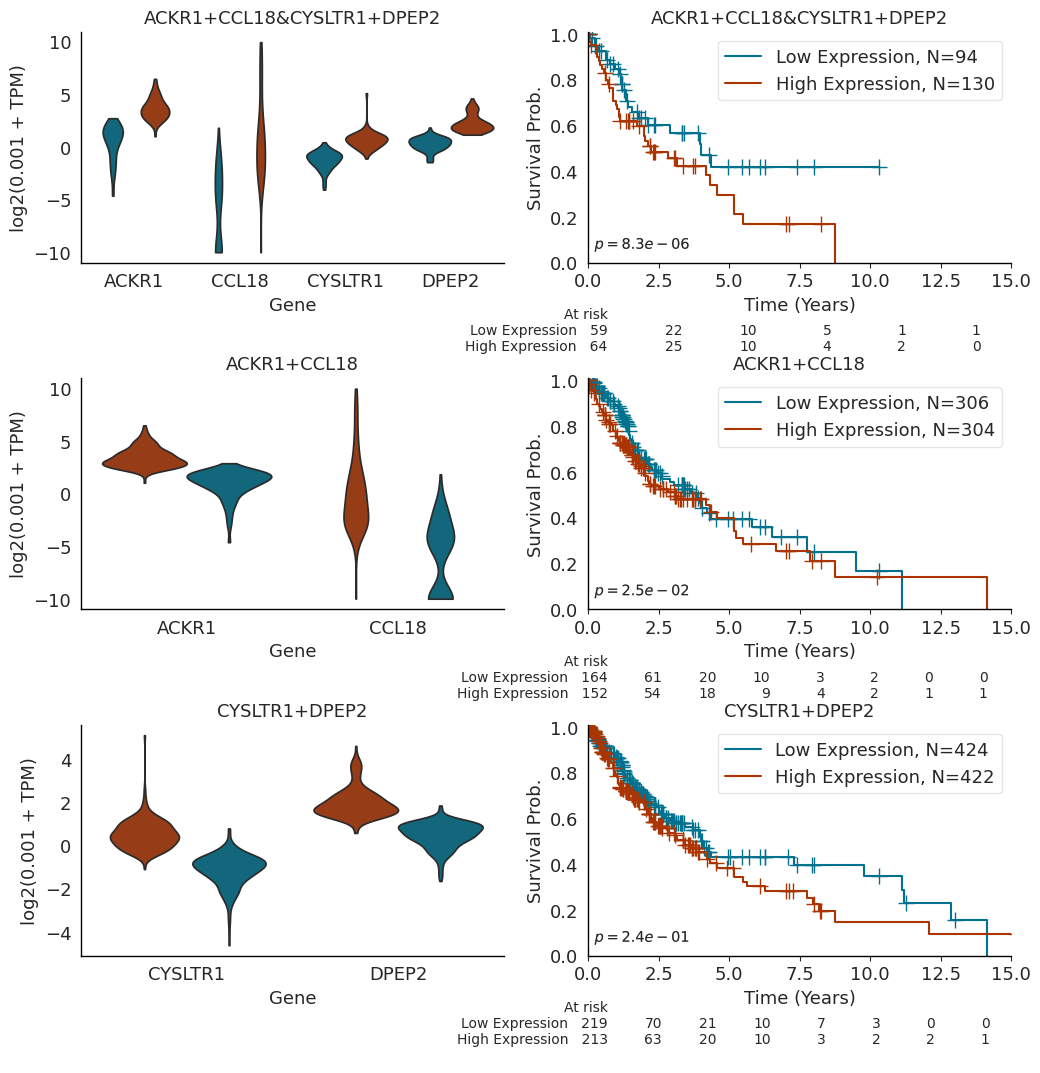

CCL3+CCR1&NRP2_PLXNA1+SEMA3G


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

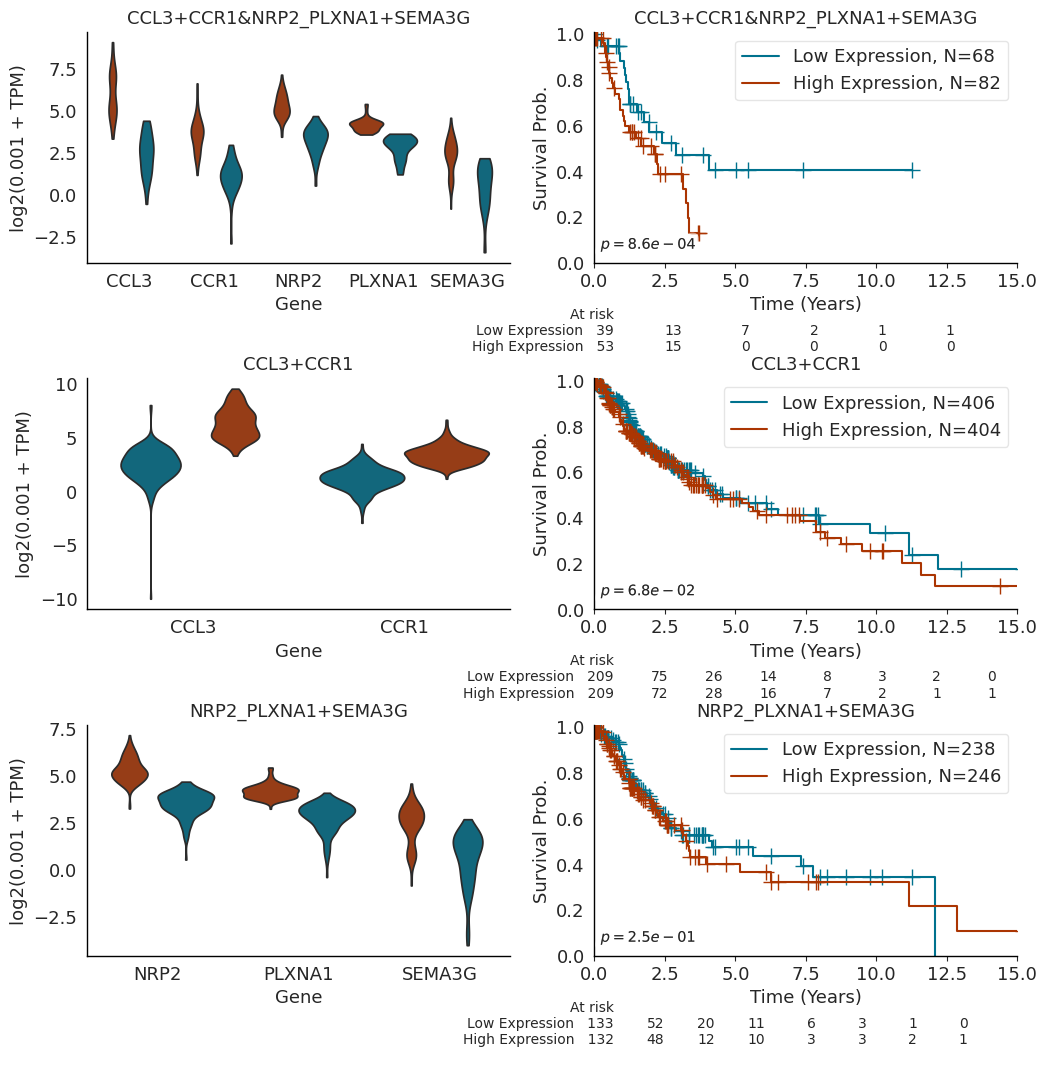

CCL8+CCR2&HCST_KLRK1+MICA


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

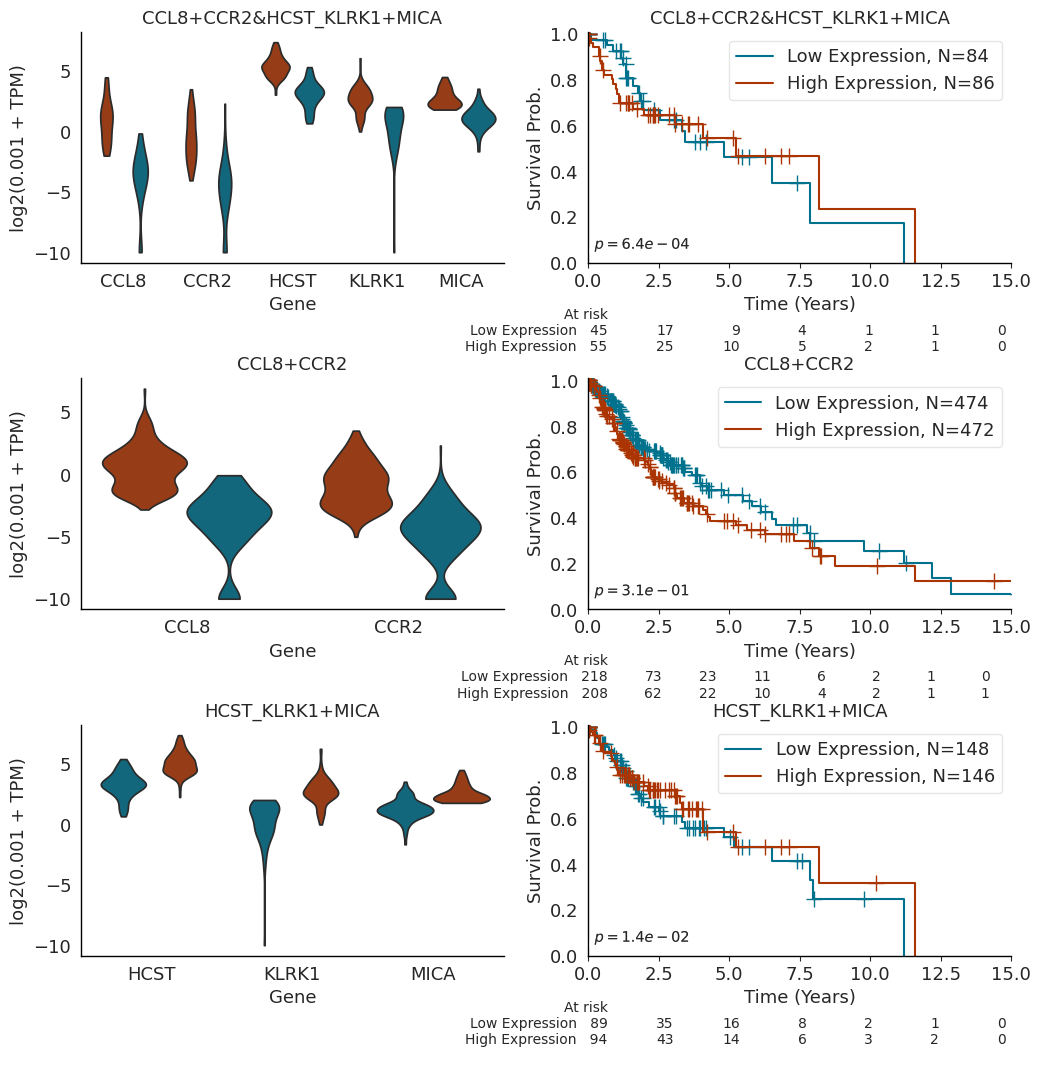




Breast
CCL8+CCR2&CX3CL1+CX3CR1


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

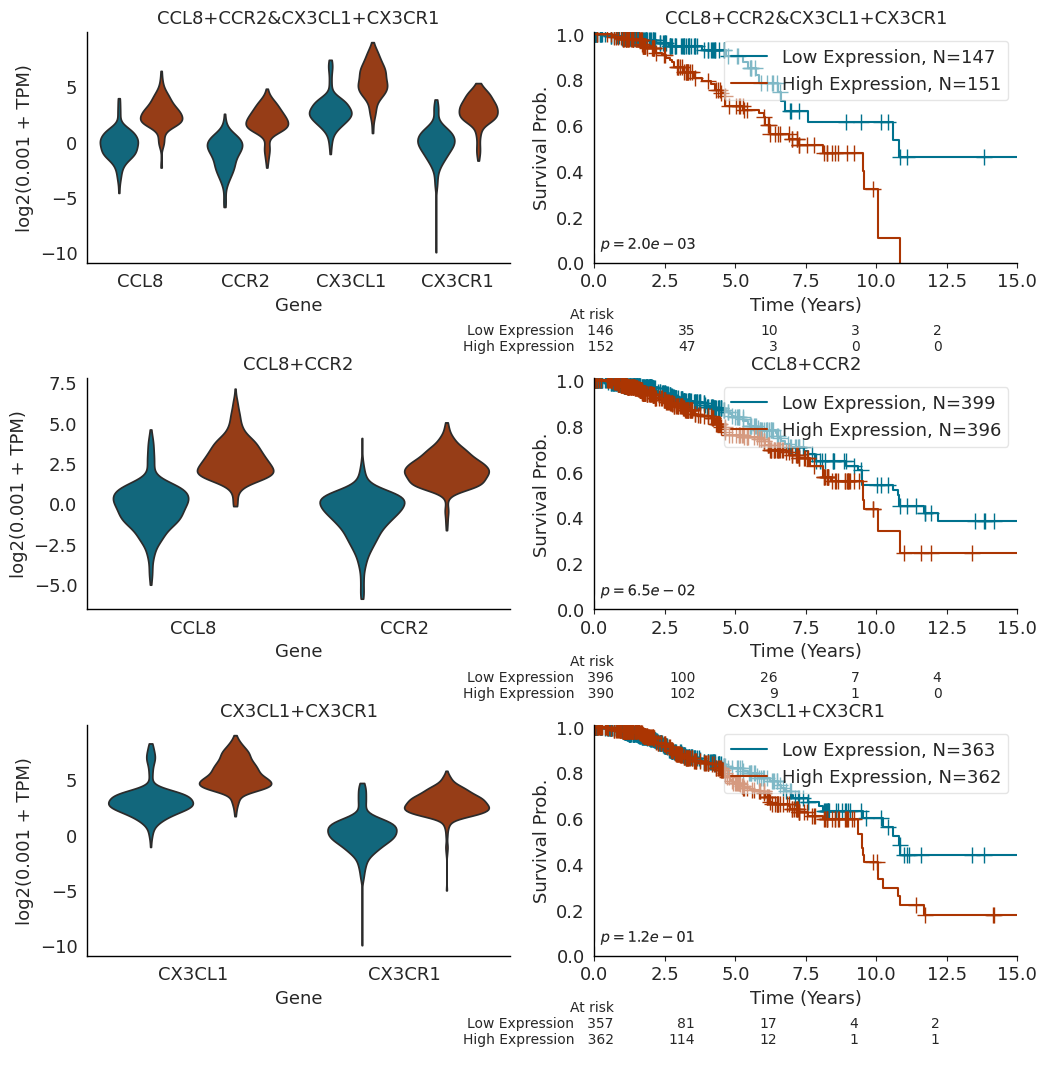

ADA2+ADORA2A&F2RL3+GZMA


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

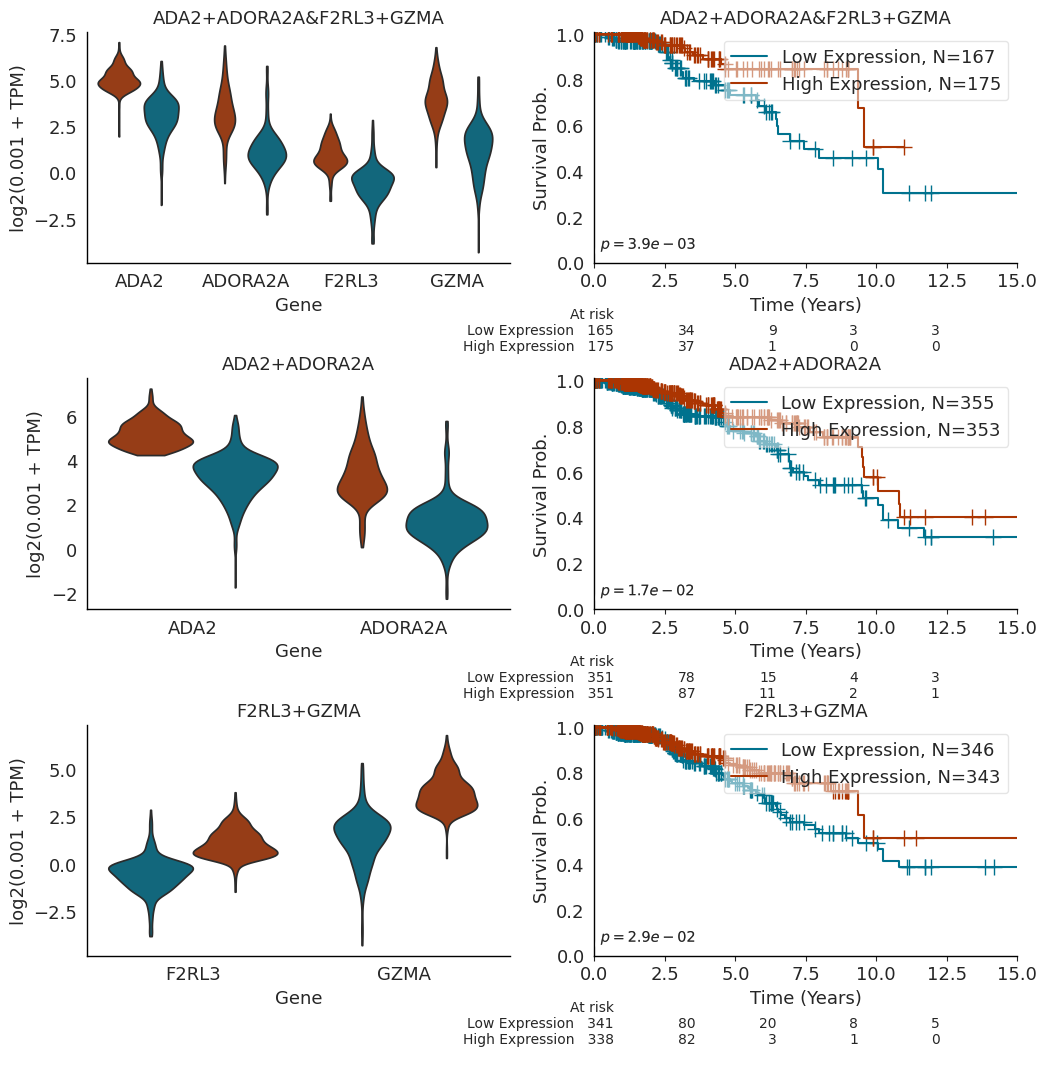

COL10A1+ITGA11_ITGB1&PLXNA1+SEMA5B


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

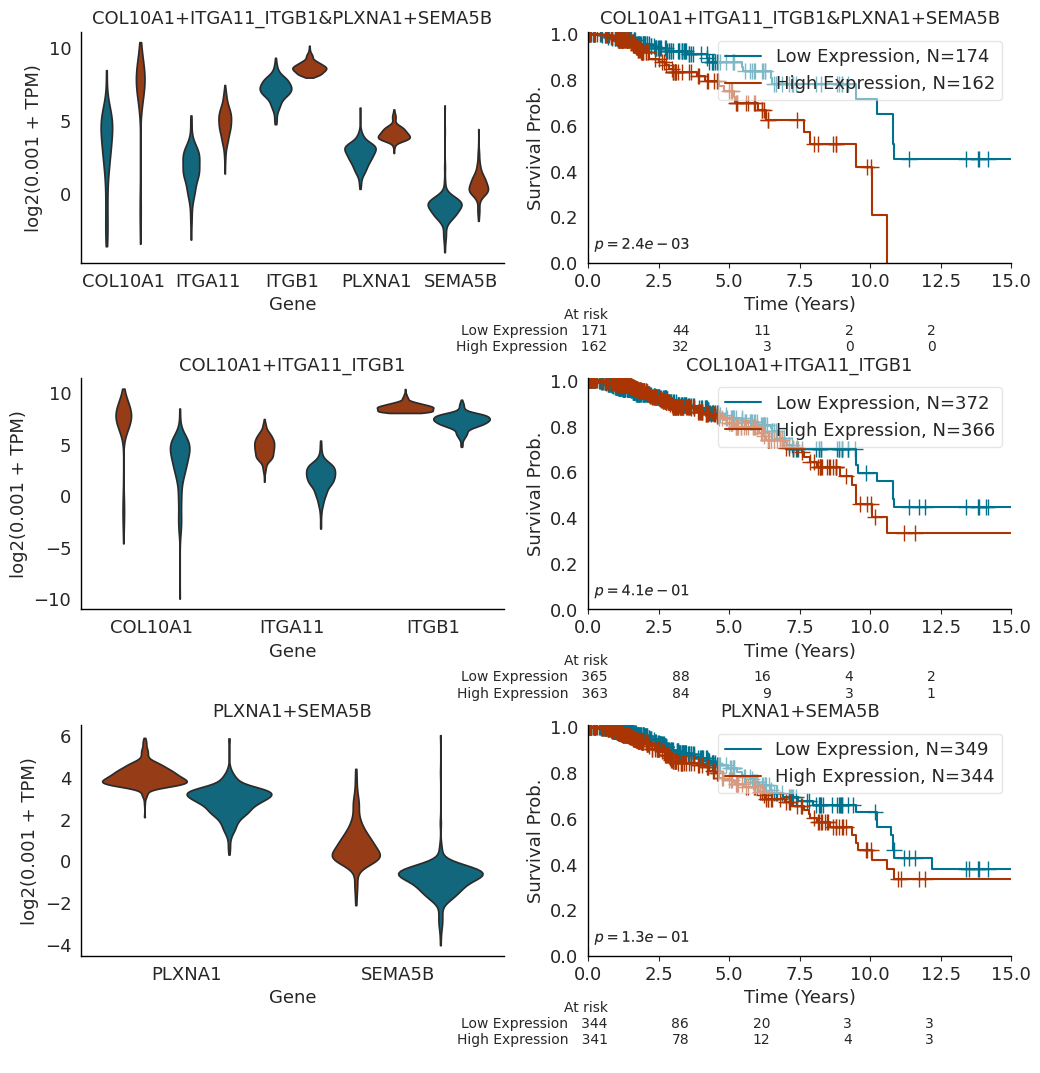

COL12A1+ITGA11_ITGB1&PLXNA1+SEMA5B


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

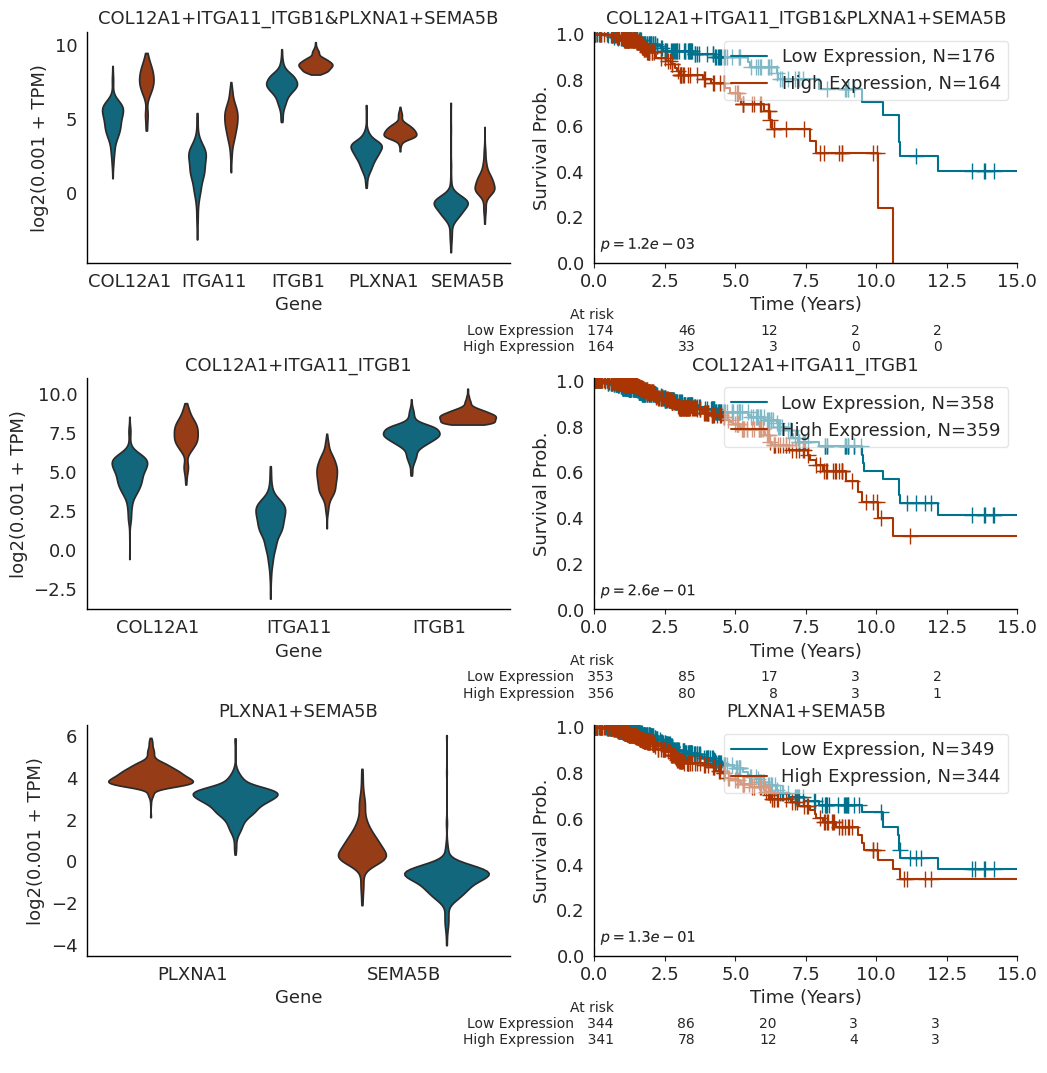

CD4+HLA-DQB1&F2RL3+GZMA


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

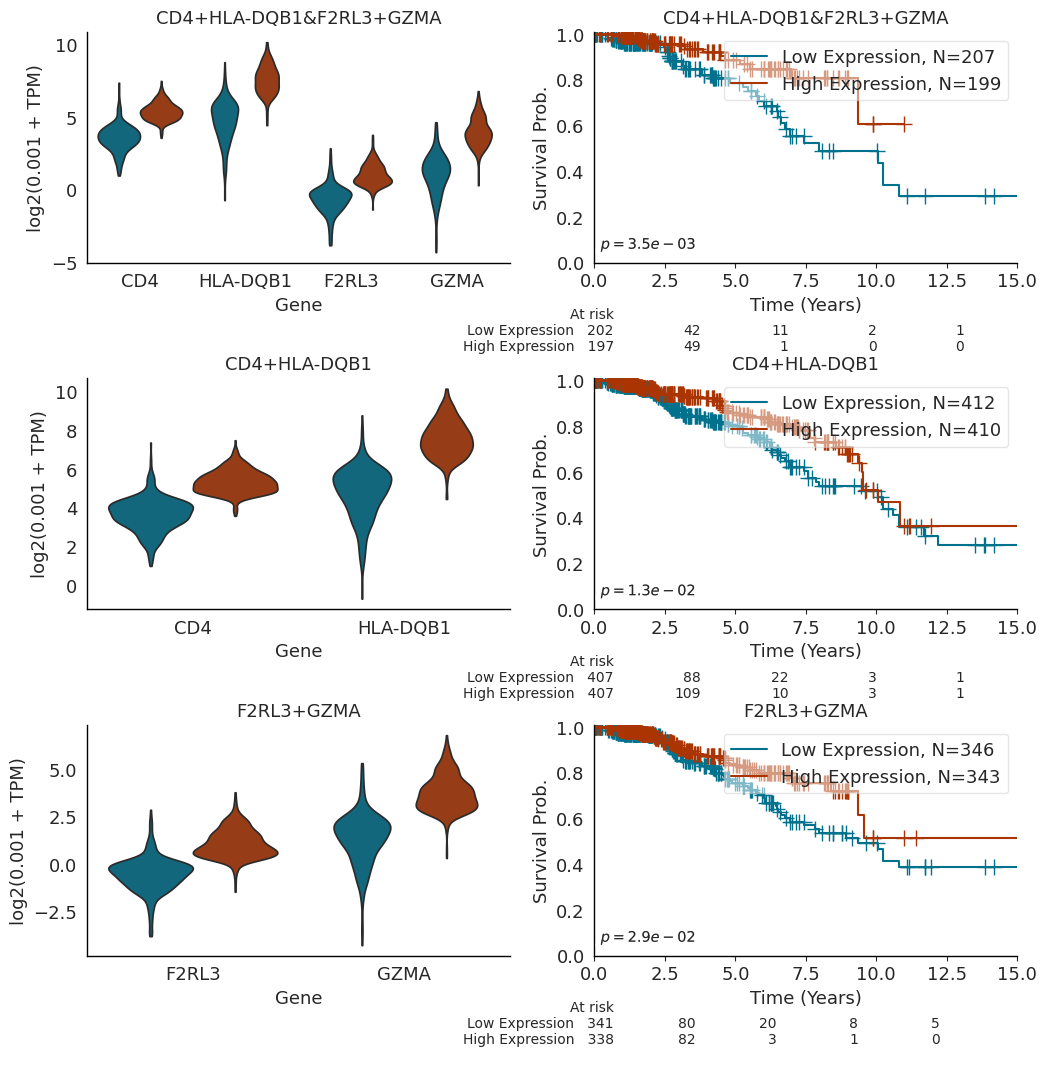




Cervix
HLA-F+LILRB2&CXCL13+CXCR5


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

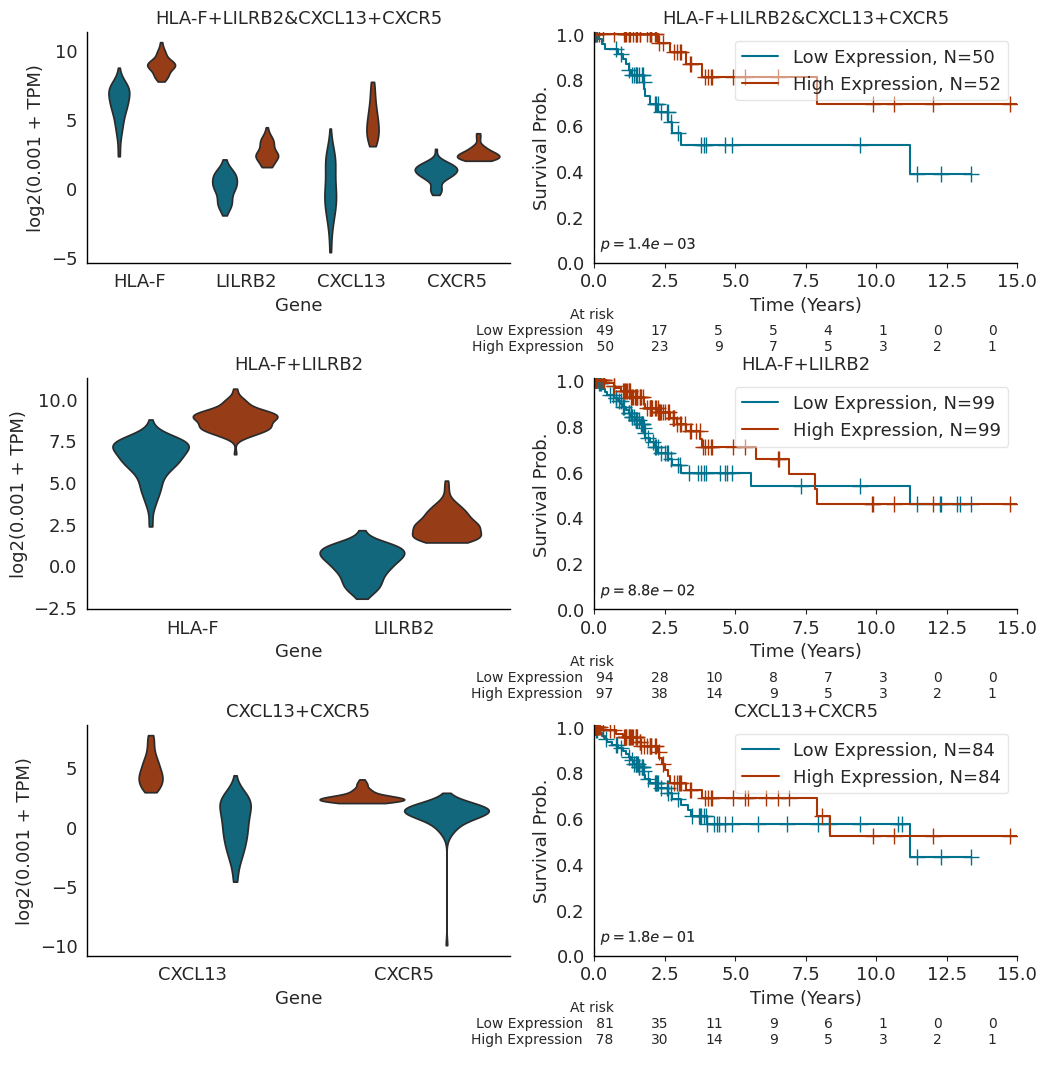

CXCL13+CXCR5&CD8A+HLA-A


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

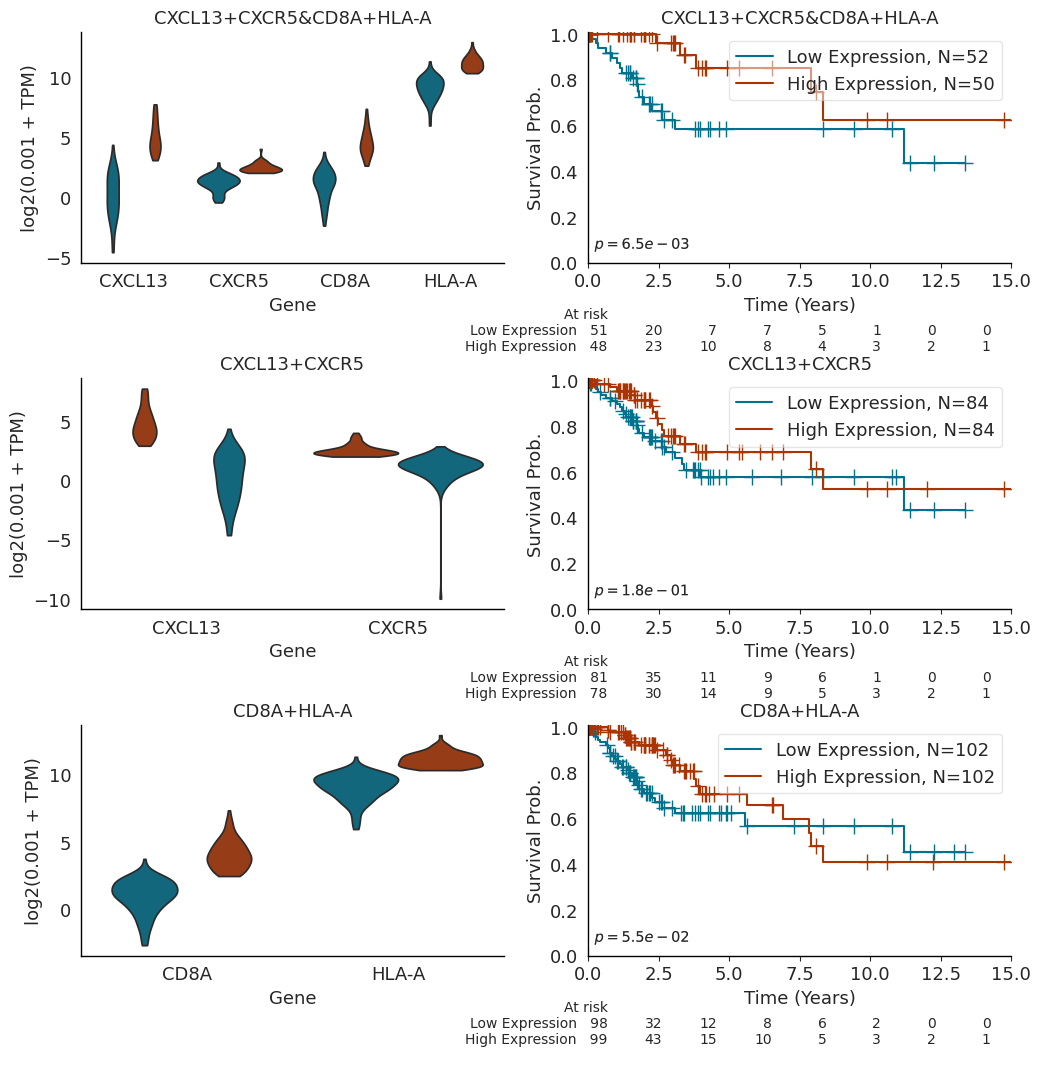

CXCL10+CXCR3&CD209+ICAM2


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

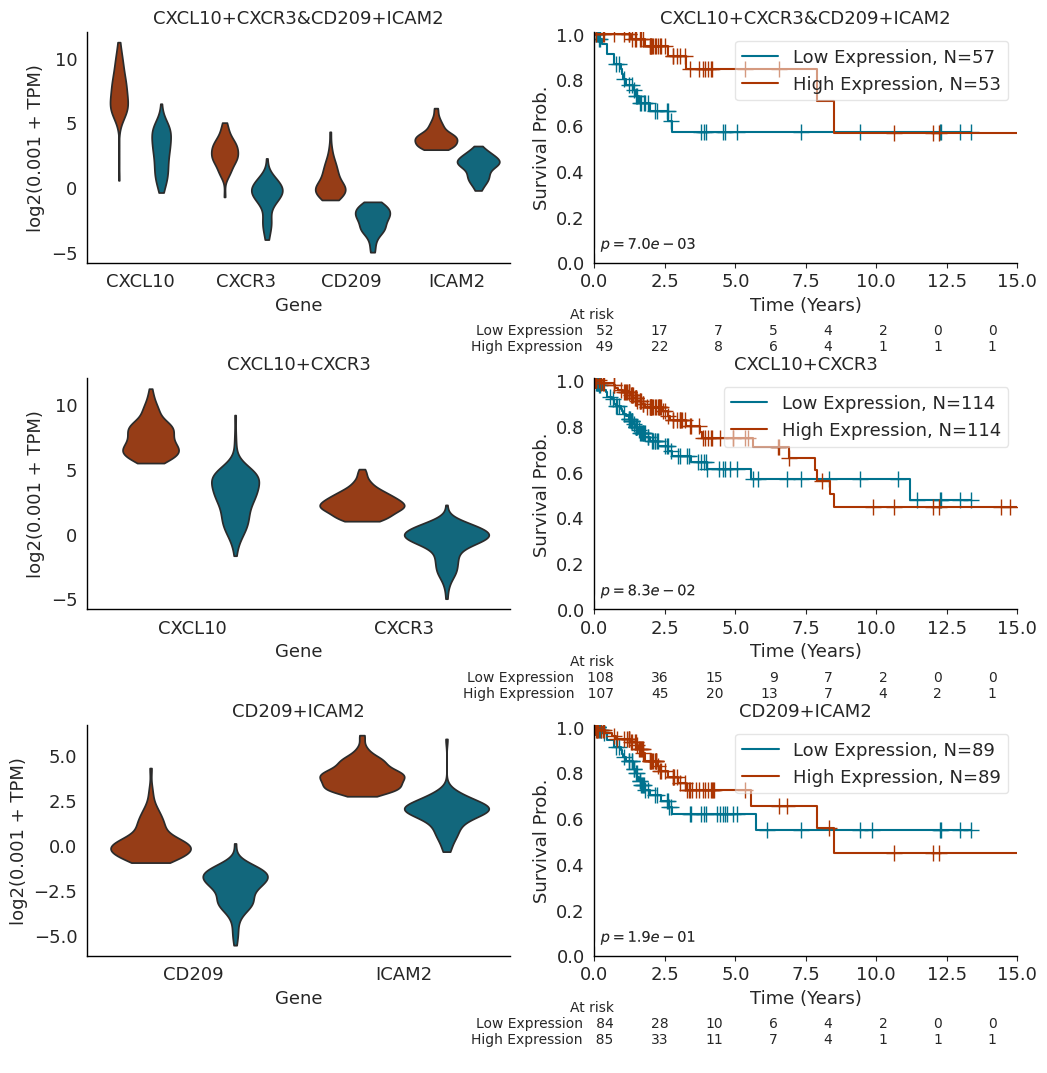




Kidney
CXCL9+CXCR3&SFRP4+WNT2


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

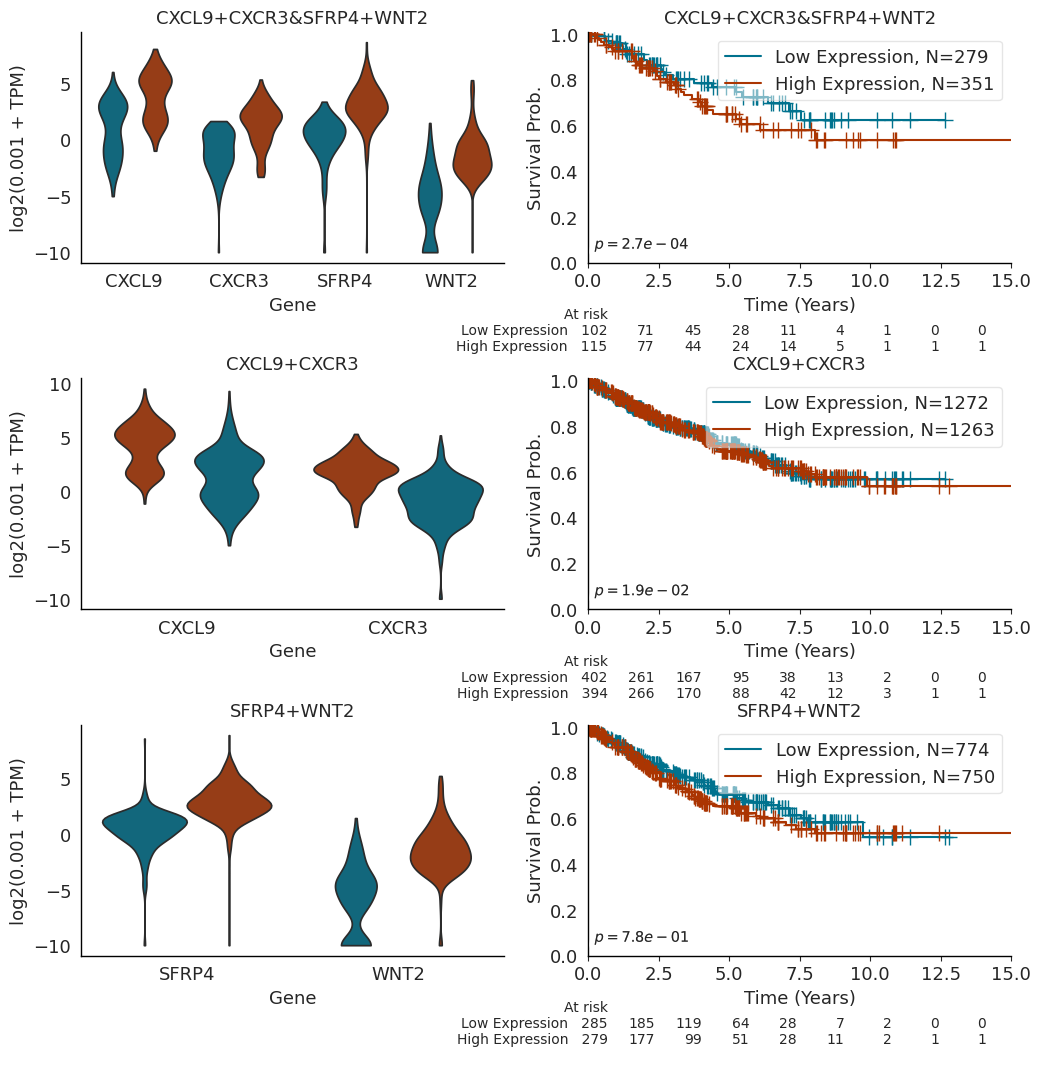

COL6A3+ITGA2_ITGB1&PLXNA1+SEMA5B



KeyboardInterrupt



<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

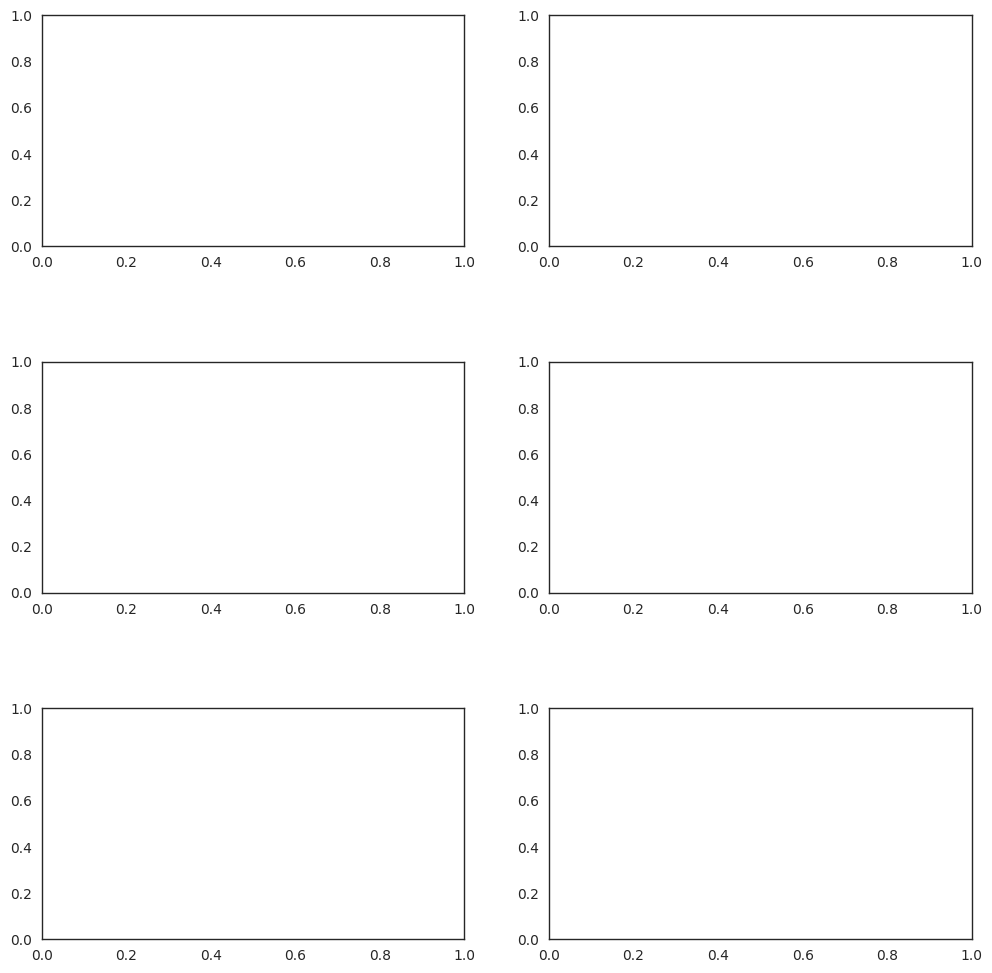

In [274]:
for tissue in to_plot['tissue'].unique():
    print(tissue)
    survival_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/survival_data/' + tissue.lower().replace(' ', '_') + '.csv', index_col=0)
    for interactions in to_plot.query('tissue == @tissue')['interaction']:
        print(interactions)
        # Uncropped
        outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'uncropped', tissue)
        os.makedirs(outdir, exist_ok=True)
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0., 1.01), show=True)#, savepath=os.path.join(outdir, interactions))
        
        # Cropped
        outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'cropped', tissue)
        os.makedirs(outdir, exist_ok=True)
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0.5, 1.005), show=False)#, savepath=os.path.join(outdir, interactions)+'_crop1')
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 10), ylim=(0.5, 1.005), show=False)#, savepath=os.path.join(outdir, interactions)+'_crop2')
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 5 ), ylim=(0.5, 1.005), show=False)#, savepath=os.path.join(outdir, interactions)+'_crop3')

    print()
    print()
    print()
    
# uncropped 0 15
# crop1 0.5 15
# crop2 0.5 10
# crop3 0.5 5

In [330]:
filtered.groupby('interaction')['tissue'].nunique().sort_values(ascending=False)[:30]

interaction
DLL4+NOTCH4&AXL+GAS6                       6
CXCL13+CXCR3&CD4+HLA-DOB                   5
COL6A3+ITGA11_ITGB1&DLL4+NOTCH4            5
ITGAV_ITGB6+TNXB&COL3A1+ITGA1_ITGB1        5
CD4+HLA-DRB5&CD52+SIGLEC10                 5
DLL4+NOTCH4&PDGFB+PDGFRA                   5
CD4+HLA-DQB1&CCL5+CCR4                     5
DLL4+NOTCH4&COL4A1+ITGA1_ITGB1             5
CXCL10+CXCR3&ACKR1+CXCL13                  5
SELL+SELPLG&CXCL13+CXCR5                   5
DLL4+NOTCH4&COL6A3+ITGA1_ITGB1             5
AXL+GAS6&PDGFC+PDGFRA                      5
DLL4+NOTCH4&COL5A3+ITGA1_ITGB1             5
CXCL13+CXCR3&HLA-E+VSIR                    4
HCST_KLRK1+MICB&TNFRSF11B+TNFSF11          4
PDGFB+PDGFRB&CD47+SIRPA                    4
ADORA2B+NT5E_SLC29A2&ITGAV_ITGB6+TNC       4
CXCL11+CXCR3&ICAM1+ITGAX_ITGB2             4
CD4+HLA-DRB5&CD274+PDCD1                   4
COL5A2+ITGA11_ITGB1&COL5A1+ITGA11_ITGB1    4
ITGAV_ITGB6+SPP1&COL11A1+ITGA11_ITGB1      4
DLL4+NOTCH4&ANGPTL2+ITGA5_ITGB1            

In [355]:
top_pairs

Index(['ACKR1+CXCL10&CD8A_CD8B+LCK', 'ACKR1+CXCL11&CXCL13+CXCR3',
       'CD36+THBS1&COL15A1+ITGA1_ITGB1', 'CD4+HLA-DOB&CXCL13+CXCR5',
       'CXCL10+CXCR3&ACKR1+CCL5', 'CXCL10+CXCR3&ACKR1+CXCL13',
       'CXCL11+CXCR3&ACKR1+CXCL13', 'CXCL11+CXCR3&CXCL13+CXCR3',
       'CXCL13+CXCR3&ACKR1+CXCL10', 'CXCL13+CXCR3&CCL5+CCR4',
       'CXCL13+CXCR3&CD8A_CD8B+LCK', 'CXCL13+CXCR3&HLA-E+KLRK1',
       'CXCL9+CXCR3&ACKR1+CXCL9', 'DLL4+NOTCH4&AXL+GAS6',
       'HLA-E+VSIR&CXCL10+DPP4', 'ICAM1+ITGB2&CXCL13+CXCR3'],
      dtype='object', name='interaction')

interaction
ACKR1+CCL18&ACKR2+CCL8                   0.633759
ACKR1+CCL18&ACKR4+CCL8                   0.647406
ACKR1+CCL18&ACVR1B_ACVR2B+INHBA_INHBB    1.073709
ACKR1+CCL18&ADA+ADORA2B                  1.520691
ACKR1+CCL18&ADORA2B+NT5E_SLC29A1         0.702297
                                           ...   
TNFRSF9+TNFSF9&SFRP4+WNT7B               0.588280
TNFRSF9+TNFSF9&TNF+TNFRSF1A              0.667808
TNFRSF9+TNFSF9&TNF+TNFRSF1B              0.578912
TNFRSF9+TNFSF9&TNFRSF11B+TNFSF11         0.356286
TNFRSF9+TNFSF9&TNFRSF8+TNFSF8            0.695602
Name: hr_lfc_best, Length: 18353, dtype: float64

tissue  hr_lfc_best
interaction                                               
DLL4+NOTCH4&AXL+GAS6                        6     0.403925
ITGAV_ITGB6+TNXB&COL3A1+ITGA1_ITGB1         5     1.086240
CD4+HLA-DRB5&CD52+SIGLEC10                  5     0.452759
COL6A3+ITGA11_ITGB1&DLL4+NOTCH4             5     0.432907
DLL4+NOTCH4&COL5A3+ITGA1_ITGB1              5     0.390521
...                                       ...          ...
CD8A+HLA-E&CD8A+HLA-A                       1     0.018317
COL5A2+ITGA2_ITGB1&COL6A3+ITGA2_ITGB1       1     0.014215
CCL3+CCR1&ADORA3+ENTPD1                     1     0.012962
CD4+HLA-DQA2&CD4+HLA-DPA1                   1     0.012665
CSF1+CSF1R&ICAM2+ITGB2                      1     0.012310

[18353 rows x 2 columns]

In [403]:
value = 'log2_hr'
#top_pairs = significant.query('motif == "4_no_crosstalk"').groupby('tissue').head(3)['interaction']

#top_pairs = significant.sort_values(
#    by=['tissue', 'c_diff_best'],
#    ascending=[True, False]
#).query('motif == "4_clique"').groupby('tissue').head(3)['interaction'].unique()

#top_pairs = to_plot.sort_values(by='tissue')['interaction'].unique()
filtered = better.set_index('interaction').query('motif in ["3_clique", "4_clique", "4_no_crosstalk"]')
filtered['sign'] = filtered['log2_hr'] > 0
n_better = filtered.groupby('interaction')['tissue'].nunique().sort_values(ascending=False)
hr_increase  = filtered.groupby('interaction')['hr_lfc_best'].median().sort_values(ascending=False)

top_pairs = n_better.to_frame().join(hr_increase).sort_values(by=['tissue', 'hr_lfc_best'], ascending=[False, False]).head(30).index

#top_pairs = significant.query('motif == "4_no_crosstalk"')['interaction'].value_counts().index[:80]
#top_pairs = significant.query('motif == "4_clique"')['interaction'].value_counts().index[:50]
#tissues = sorted([tissue for tissue in to_plot.tissue.unique() if tissue != 'Pan_Cancer'])
tissues = sorted([tissue for tissue in filtered.loc[top_pairs].tissue.unique() if tissue != 'Pan_Cancer'])

df = crosstalkdf.set_index('interaction').loc[top_pairs, ['tissue', value, 'logrank_pval']].reset_index()
df = df.query('tissue in @tissues')
df['size'] = -np.log10(df['logrank_pval'].astype(float))
#df['size'].clip(df['size'].quantile(0.05), df['size'].quantile(0.95))
df['size'] = df['size'].clip(0, 10)
#df = df.drop(columns='pval_adj')

df = df.set_index(['interaction', 'tissue'])
df['is_significant'] = False

singificant_pairs = better.set_index(['interaction', 'tissue']).index.intersection(df.index)
df.loc[singificant_pairs, 'is_significant'] = True

df = df.reset_index()

# Sort interactions
df['interaction'] = pd.Categorical(df['interaction'], top_pairs, ordered=True)
df['tissue'] = pd.Categorical(df['tissue'], tissues, ordered=True)

motifs_df = crosstalkdf.set_index('interaction').loc[df.interaction, 'motif'].to_frame().reset_index().drop_duplicates().sort_values(by='motif')
cliques = motifs_df.query('motif in ["3_clique", "4_clique"]')['interaction'].unique()

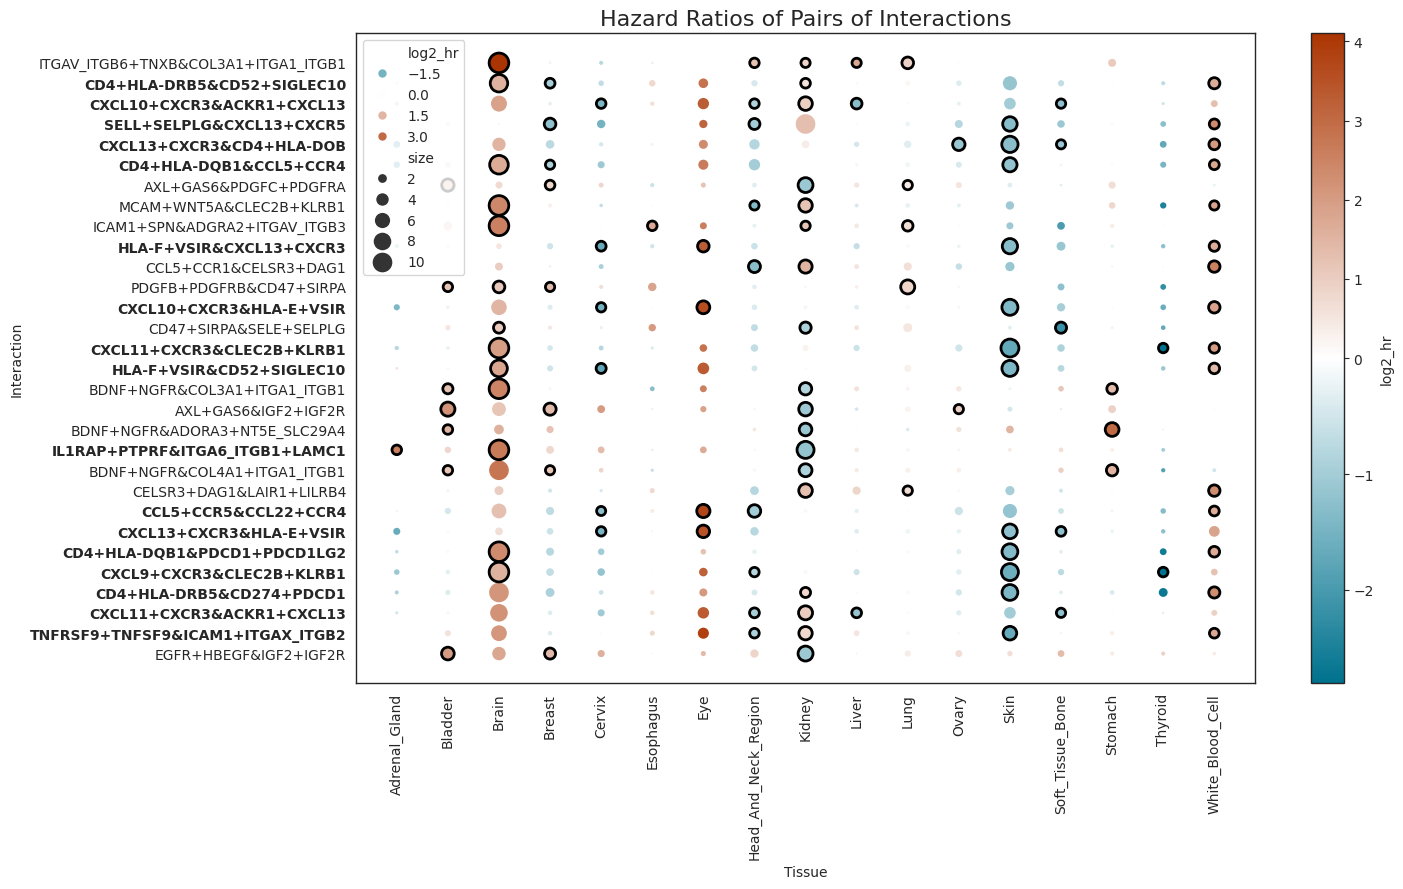

In [405]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import ticker

# Define custom colormap
colors = [ncolor, 'white', tcolor]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
norm = TwoSlopeNorm(vmin=df[value].quantile(0.), vcenter=0, vmax=df[value].quantile(1))

# Create the scatter plot
plt.figure(figsize=(15, 9))

# Calculate size scaling
sizes = (0, 200)
size_min, size_max = sizes
factor = (size_max - size_min) / (df['size'].max() - df['size'].min())

# Plot base scatterplot
scatter = sns.scatterplot(
    data=df,
    x="tissue",
    y="interaction",
    size="size",
    hue=value,
    hue_norm=norm,
    palette=custom_cmap,
    sizes=sizes,
    linewidth=0
)

# Highlight significant points
significant_points = df[df['is_significant']]
plt.scatter(
    x=significant_points['tissue'],
    y=significant_points['interaction'],
    s=size_min + (significant_points['size'] - df['size'].min()) * factor,
    edgecolor='black',
    facecolor='none',
    linewidth=2
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), label=value)

# Enhance plot aesthetics
plt.xticks(rotation=90)

# Customize the first 5 y-axis labels to make them bold
ax = plt.gca()
y_labels = ax.get_yticklabels()

# Modify the first 5 labels
for i, label in enumerate(y_labels):
    if label._text in cliques:  # First 5 labels
        label.set_fontweight('bold')
        #label.set_color('red')
ax.set_yticklabels(y_labels)

plt.title("Hazard Ratios of Pairs of Interactions", fontsize=16)
plt.xlabel("Tissue")
plt.ylabel("Interaction")
plt.tight_layout()
plt.show()
